# Поиск наиболее похожих товаров маркетплейса

**Цель работы**: разработать алгоритм, который для множества товаров А подбирает несколько вариантов наиболее похожих товаров из множества В.


**Описание данных**

base.csv - анонимированный набор товаров. Каждый товар представлен как уникальный id и вектор признаков размерностью 72.
train.csv - каждая строка - один товар, для которого известен уникальный id, вектор признаков и id товара из base, который максимально похож на него. 
validation.csv - товары, для которых требуется найти наиболее близкие товары из base.csv.

## Загрузка и анализ данных

In [1]:
!pip install ydata-profiling
!pip install faiss-cpu
%matplotlib inline


In [2]:
import pandas as pd
import numpy as np
from scipy.stats import zscore
import matplotlib.pyplot as plt
#import pandas_profiling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
import faiss
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import phik
from phik import resources, report
import seaborn as sns
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster
from sklearn.cluster import AgglomerativeClustering 
from scipy.spatial import distance_matrix, distance 

C:\Users\Танька\AppData\Local\Temp\ipykernel_12236\1583752595.py:5: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  import pandas_profiling


In [3]:
pd.set_option('display.max_columns', 80)

In [4]:
# При анализе выбросов будем считать возможными выбросами значения, лежащие за пределами 2 стандартных отклонений
MAXZ = 2

#Ищем 5 наиболее похожих товаров
k = 5

SEED = 123

In [5]:
dict_base = {}
for i in range(72):
    dict_base[str(i)] = 'float32'
dict_base
dict_train = dict_base.copy()
dict_train['Target'] = 'str'

In [6]:
df_base = pd.read_table(r'C:\Users\Танька\TestFolder\Matching\base.csv', index_col=0, sep=',', dtype=dict_base)
#df_train = pd.read_csv("/kaggle/input/yp-matching/train.csv", index_col=0)
#df_base = df_base.head(500000)
df_base.head(3)

0          1          2           3           4           5  \
Id                                                                             
0-base -115.083893  11.152912 -64.426758 -118.880890  216.482437 -104.698059   
1-base  -34.562202  13.332763 -69.787613 -166.533478   57.680607  -86.098373   
2-base  -54.233746   6.379371 -29.210136 -133.413834  150.895828  -99.435326   

                 6          7           8           9          10          11  \
Id                                                                              
0-base -469.070587  44.348083  120.915344  181.449707 -124.061508  -32.458237   
1-base  -85.076668 -35.637436  119.718636  195.234192 -141.304352 -126.768898   
2-base   52.554794  62.381706  128.951447  164.381470 -140.822449  -22.486748   

               12         13          14         15         16         17  \
Id                                                                          
0-base -57.420559  36.207405  182.716766 -28.071688  -5.209374  -1.732183   
1-base -68.853531   8.314717  143.081741   8.778257  15.157185  48.246361   
2-base -51.666988   2.521726  140.585449 -22.039230  -7.128633  -5.184787   

                18         19          20           21         22         23  \
Id                                                                             
0-base  -91.091858 -79.466667 -103.939087  1507.231323 -32.591667  51.414360   
1-base -244.954865 -80.279419  -81.788040   429.880035  -5.937690  70.142654   
2-base -111.712120 -79.029266  -82.452576  1507.231323  -0.421011  84.108009   

               24          25          26         27          28          29  \
Id                                                                             
0-base -51.905361  813.770081  -41.556538   8.419807 -129.976639  148.765030   
1-base  66.576843  813.770081    3.214371  17.164303  -39.418385  148.155884   
2-base  63.344509  813.770081 -105.211052  18.844700  -94.789474  151.387711   

               30          31          32          33         34          35  \
Id                                                                             
0-base -10.069234 -143.005035   79.848694 -537.183716   2.773180  111.518677   
1-base  -7.579590 -174.369949  101.224632 -303.939240  16.914631   53.394676   
2-base -21.483440 -144.845367   48.502934 -780.449158  64.767311   79.781555   

               36          37          38         39         40         41  \
Id                                                                           
0-base   4.257666 -153.340576 -123.626083 -39.707664 -12.768708  -4.170106   
1-base  33.451824 -148.552628 -110.340172 -33.277206  -8.688703  13.650302   
2-base -13.390142 -150.061661 -118.758553 -40.896286 -15.222620  -1.860338   

                42         43         44         45          46          47  \
Id                                                                            
0-base -152.967133  75.911522 -57.470089  17.266476  -98.871155 -138.067535   
1-base  -91.228745  38.445015 -31.948471  62.484821 -166.473358 -189.010422   
2-base  -93.820656  98.749069 -46.745781  65.927475  -10.286392 -125.321373   

               48          49         50         51         52          53  \
Id                                                                           
0-base  91.000381 -170.701996 -50.020390  59.794296  78.106377  -89.375725   
1-base -56.731556  -30.027319  59.171059 -56.711540  63.542606 -121.319168   
2-base  21.048609  -22.637775  68.915985 -54.902260  66.335472 -142.927917   

               54        55          56         57          58          59  \
Id                                                                           
0-base  89.412102  79.81218 -129.513611 -44.659496  -80.442207    5.149714   
1-base  97.426056  74.83284 -138.777054  58.887608  -71.595337 -251.952362   
2-base  83.030983  69.97963 -123.733887  65.320877 -114.037178 -529.396973   

                60          61          62         6

In [7]:
df_base.shape

(2918139, 72)

In [8]:
df_base.dtypes

0     float32
1     float32
2     float32
3     float32
4     float32
       ...   
67    float32
68    float32
69    float32
70    float32
71    float32
Length: 72, dtype: object

In [9]:
base_index = {k: v for k, v in enumerate(df_base.index.to_list())}

In [10]:
df_train = pd.read_csv(r'C:\Users\Танька\TestFolder\Matching\train.csv', index_col=0, dtype=dict_train)
df_train.head()

0          1           2           3           4           5  \
Id                                                                              
0-query -53.882748  17.971436  -42.117104 -183.936676  187.517487  -87.144928   
1-query -87.776367   6.806268  -32.054546 -177.260391  120.803329  -83.810593   
2-query -49.979565   3.841486 -116.118591 -180.401978  190.128433  -50.837620   
3-query -47.810562   9.086598 -115.401695 -121.011360   94.652840 -109.255409   
4-query -79.632126  14.442886  -58.903397 -147.052536   57.127068  -16.239529   

                  6          7           8           9          10  \
Id                                                                   
0-query -347.360596  38.307602  109.085564   30.413513  -88.082687   
1-query  -94.572746 -78.433090  124.915901  140.331070 -177.605804   
2-query   26.943937 -30.447489  125.771164  211.607819  -86.346558   
3-query -775.150146  79.186523  124.003098  242.650650 -146.517075   
4-query -321.317963  45.984676  125.941284  103.392670 -107.153023   

                 11         12         13          14         15         16  \
Id                                                                            
0-query  -52.695541 -27.692442   4.872923  198.348007 -30.075249  -3.803569   
1-query  -84.995514  42.810810 -57.256332   96.792534 -19.261467   0.739535   
2-query  -35.666546  16.395317 -80.802849  137.908646 -23.532761 -47.256584   
3-query -159.469849 -13.844755  -6.113928  118.939255 -44.585907   9.559358   
4-query   -8.800034 -50.977798  29.457338  143.389313   5.614824 -45.274761   

                 17          18         19         20           21         22  \
Id                                                                              
0-query -135.810608 -161.841370 -78.512177 -94.428940   898.436951 -70.140518   
1-query   50.619213 -155.267029 -78.659431 -92.761490   353.157745 -34.744545   
2-query  -16.650242 -194.505676 -78.372925 -69.324478  1507.231323 -52.500969   
3-query   14.435648 -156.906830 -78.789322 -78.737091  1507.231323  19.957405   
4-query    9.643625  -77.554626 -79.066612 -77.926460  1507.231323  16.612400   

                 23          24          25          26         27  \
Id                                                                   
0-query   78.420357  108.032776  813.770081  -74.790878  12.610422   
1-query   82.487106  -28.450592  813.770081 -137.529633  26.595627   
2-query  -34.165775   52.958652  813.770081  -18.021725  20.951107   
3-query   34.834290   -8.820732  813.770081 -125.606796  17.584084   
4-query  116.284286   33.754898  813.770081 -105.765335   6.523008   

                 28          29         30          31          32  \
Id                                                                   
0-query -183.821838  149.715836 -27.042316 -133.212173  106.420746   
1-query -136.783447  153.357910  48.810093 -115.922150   87.464218   
2-query  -50.321781  158.760620   0.178065 -183.069672   99.053574   
3-query  -58.452904  141.281799 -54.959309 -136.988541   63.880493   
4-query  -19.812988  157.693924 -20.604088 -146.591278   78.849571   

                  33         34         35         36          37          38  \
Id                                                                              
0-query  -303.939240  48.730789  58.185707  24.250950 -151.224106 -104.282265   
1-query  -222.286362  25.124149  91.887138 -30.636869 -136.593140 -140.500122   
2-query -1018.469543 -51.801121  97.766769 -10.865850 -144.423157 -133.819489   
3-query -1018.469543  89.228928  65.919960 -24.078644 -152.334106  -91.199379   
4-query  -780.449158  87.560768  73.036659  16.891029 -144.657898 -116.122147   

                39         40        41          42          43         44  \
Id                                                                           
0-query -34.492809 -12.587054  2.622891 -120.969917  149.991638 -31.948471   
1-query -43.449757  -7.226884  8.265747 -117.915466 

In [11]:
df_train.shape

(100000, 73)

In [12]:
df_train.dtypes

0         float32
1         float32
2         float32
3         float32
4         float32
           ...   
68        float32
69        float32
70        float32
71        float32
Target     object
Length: 73, dtype: object

In [13]:
df_valid = pd.read_csv(r'C:\Users\Танька\TestFolder\Matching\validation.csv', index_col=0, dtype=dict_base)
df_valid.head()

0          1          2           3           4  \
Id                                                                      
100000-query -57.372734   3.597752 -13.213642 -125.926788  110.745941   
100001-query -53.758705  12.790300 -43.268543 -134.417618  114.449913   
100002-query -64.175095  -3.980927  -7.679249 -170.160934   96.446159   
100003-query -99.286858  16.123936   9.837166 -148.060440   83.697083   
100004-query -79.532921  -0.364173 -16.027431 -170.884949  165.453918   

                       5           6           7           8           9  \
Id                                                                         
100000-query  -81.279594 -461.003174  139.815720  112.880981   75.215752   
100001-query  -90.520126 -759.626038   63.995087  127.117905   53.128998   
100002-query  -62.377739 -759.626038   87.477554  131.270111  168.920319   
100003-query -133.729721   58.576405  -19.046659  115.042404   75.206734   
100004-query  -28.291668   33.931934   34.411217  128.903976  102.086914   

                      10          11         12         13          14  \
Id                                                                       
100000-query -131.892807 -140.968567 -57.987164 -22.868887  150.895523   
100001-query -153.717255  -63.951328 -52.369495 -33.390945  148.619507   
100002-query -220.309540  -31.378445  -8.788761   2.285323  133.266113   
100003-query -114.271957  -71.406456 -65.349319  24.377069   50.467300   
100004-query  -76.214172  -26.393860  34.423641  50.938889  157.683182   

                     15         16         17          18         19  \
Id                                                                     
100000-query   7.965574  17.622066 -34.868217 -216.138550 -80.908730   
100001-query -22.483829  15.164185 -56.202000 -153.614380 -79.831825   
100002-query -41.309078  14.305538 -18.231812 -205.533707 -78.160309   
100003-query -14.721335  15.069309 -46.682995 -176.604370 -78.690697   
100004-query -23.786497 -33.175415  -0.592607 -193.318542 -79.651031   

                      20           21         22          23         24  \
Id                                                                        
100000-query  -52.579521   263.363129  56.266876   66.924713  21.609911   
100001-query -101.055481  1203.537109  81.597130  101.018654  56.783424   
100002-query  -96.607674  1507.231323  -5.964200   34.937443 -56.086887   
100003-query -139.227448   325.547119   3.632292   74.929504  -4.802103   
100004-query  -91.889786  1358.481079  44.027733  121.527206  46.182999   

                      25          26         27         28          29  \
Id                                                                       
100000-query  813.770081  -32.782940  20.794031 -79.779076  156.307083   
100001-query   92.209625 -126.860336  10.382887 -38.523361  165.383911   
100002-query  813.770081  -13.200474  18.966661 -35.110191  151.368500   
100003-query  813.770081  -52.982597  15.644382 -54.087467  151.309143   
100004-query  433.623108  -82.233200  21.068508 -32.940117  149.268951   

                     30          31          32          33          34  \
Id                                                                        
100000-query -42.831329  -71.723335   83.283661 -304.174377    1.609402   
100001-query -77.840485 -169.538681  103.483238 -915.735718   16.109938   
100002-query -17.490252 -145.884293   15.533379 -655.395508   39.412827   
100003-query  21.088570 -134.507889   65.118958 -529.295044  131.565521   
100004-query   0.404718  -97.674530   81.719994 -825.644775    9.397169   

                     35         36          37          38         39  \
Id                                                                      
100000-query  55.834587 -29.474255 -139.162766 -126.038353 -62.643829   
100001-query  14.669937 -38.707085 -149.538376 -138.792923 -36.076176   
100002-query  62.554955   9.924992 -143.934616 -123.107796 -37.032475   
100003-query  67.

In [14]:
df_samples = df_train[:5000]

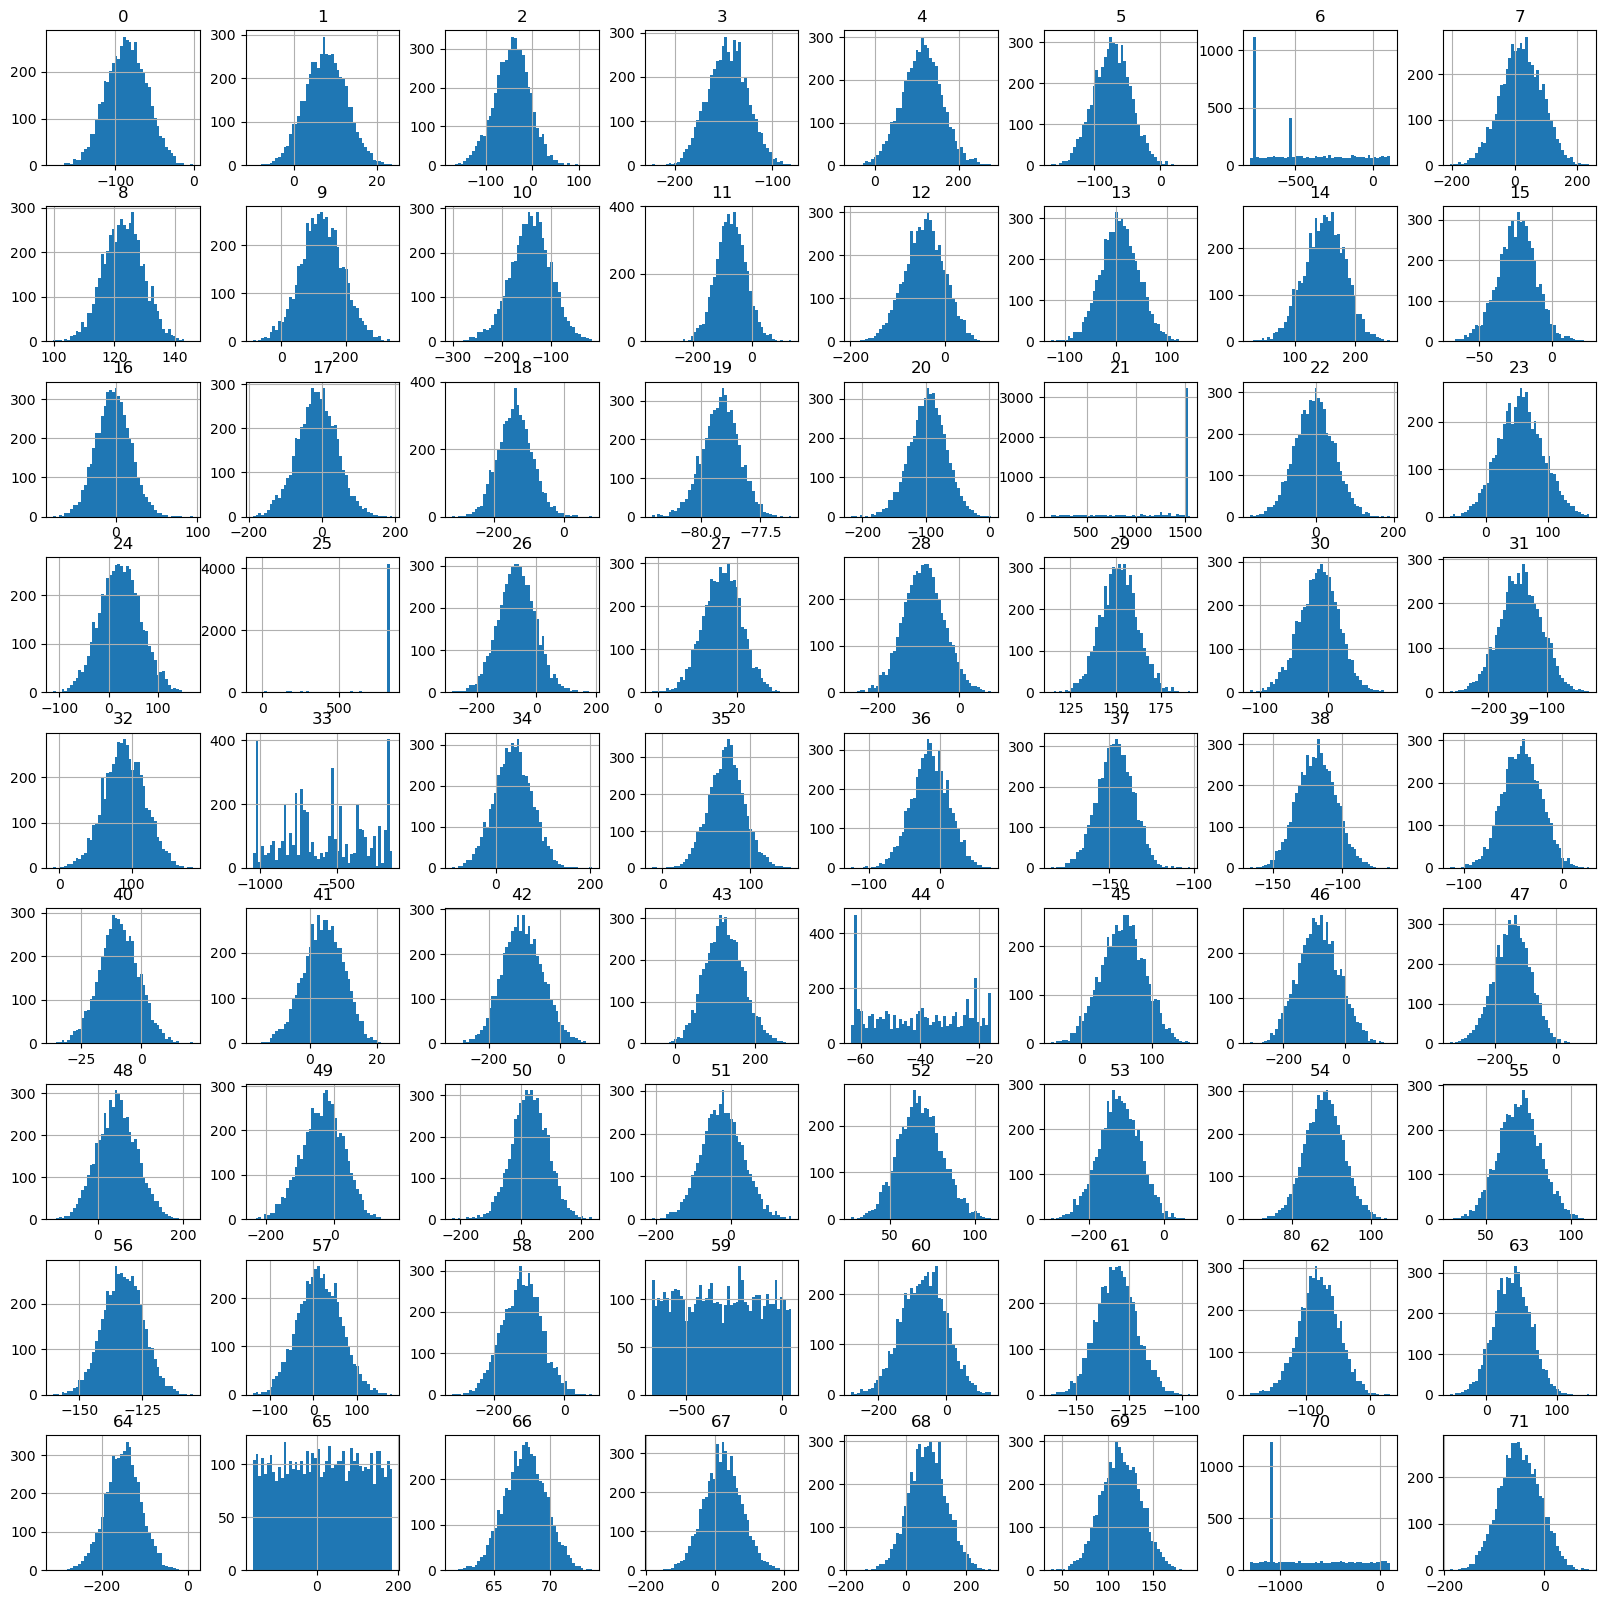

In [15]:
df_samples.hist(figsize=[20, 20], bins=50);

Рассмотрим подробнее признаки, для которых наблюдается большой разброс в данных. Найдем выбросы и удалим их:

Расчет с неудаленными выбросами показывает большие значения метрики, т.е. широкий разброс в данных не является выбросом и позволяет лучше идентифицировать группы товаров.

In [17]:
df_train.shape

(100000, 73)

In [18]:
df_train.isna().sum().sum()

0

In [19]:
df_train.duplicated().sum()

0

Пропуски и дубликаты в данных отсутствуют.

## Подготовка выборок

В работе тестировать алгоритмы начнем с 2х функциональностей: алгоритма кластеризации NearestNeighbors и библиотеки FAISS. Т.к. для них может потребоваться производить разные преобразования, подготовим отдельные выборки:

In [20]:
# для kNN
base_v0 = df_base[:10000]
train_v0 = df_train[:10000]
valid_v0 = df_valid[:10000]

In [21]:
def find_number(target):
    return int(target.split('-')[0])

In [22]:
train_v0['number'] = train_v0['Target'].apply(find_number)

C:\Users\Танька\AppData\Local\Temp\ipykernel_12236\614198725.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_v0['number'] = train_v0['Target'].apply(find_number)


In [23]:
df_train_v0 = train_v0.drop(['Target', 'number'], axis=1)
target_train_v0 = train_v0[['Target','number']]

In [24]:
#!
targets = df_train['Target']
features_train = df_train.drop('Target', axis=1)

## Проверка на мультиколлинеарность

In [34]:
multi = add_constant(features_train)
coefs = pd.Series([variance_inflation_factor(multi.values, i) 
               for i in range(multi.shape[1])], 
              index=multi.columns)

In [35]:
coefs.sort_values(ascending=False).head(20)

const    14054.564853
21           1.044574
6            1.042354
33           1.040905
44           1.037021
52           1.028265
43           1.024373
47           1.024047
51           1.023278
9            1.023015
60           1.022784
22           1.022316
49           1.021865
45           1.021791
4            1.021657
39           1.021632
35           1.021267
15           1.021218
30           1.020908
36           1.020805
dtype: float64

In [36]:
train_v0.corr()['number'].sort_values(ascending=False).head(20)

number    1.000000
6         0.137455
21        0.055658
46        0.038122
8         0.034418
68        0.027399
18        0.022329
44        0.020907
1         0.013949
13        0.013093
22        0.013041
31        0.012710
25        0.012500
48        0.012459
37        0.011293
62        0.011014
47        0.010856
35        0.010740
14        0.010638
69        0.010314
Name: number, dtype: float64

In [37]:
train_v0.corr()['number'].sort_values(ascending=False).tail(20)

29   -0.009883
19   -0.010149
41   -0.010938
63   -0.011203
0    -0.011388
27   -0.011631
9    -0.012007
50   -0.012983
23   -0.013183
28   -0.014957
59   -0.017987
33   -0.019186
32   -0.020190
43   -0.020580
36   -0.022376
5    -0.024387
53   -0.025210
64   -0.025229
17   -0.026602
42   -0.027436
Name: number, dtype: float64

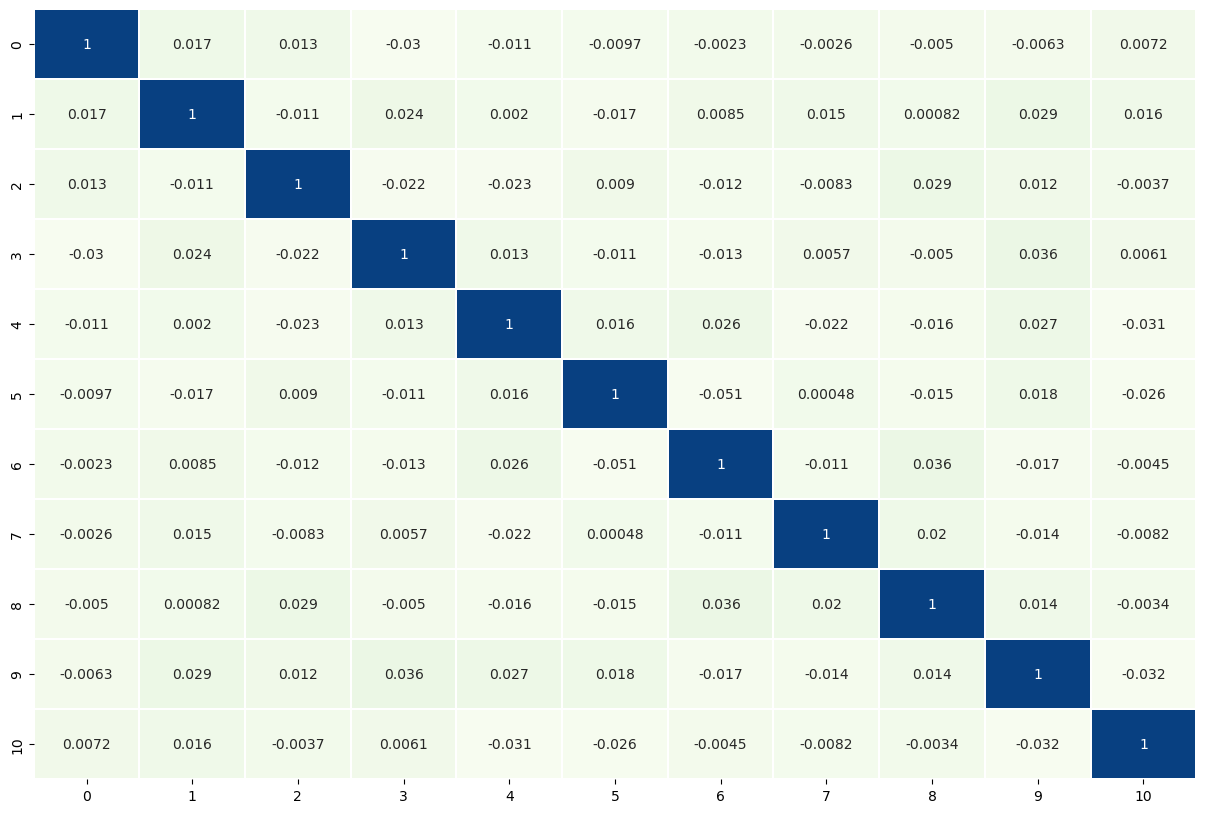

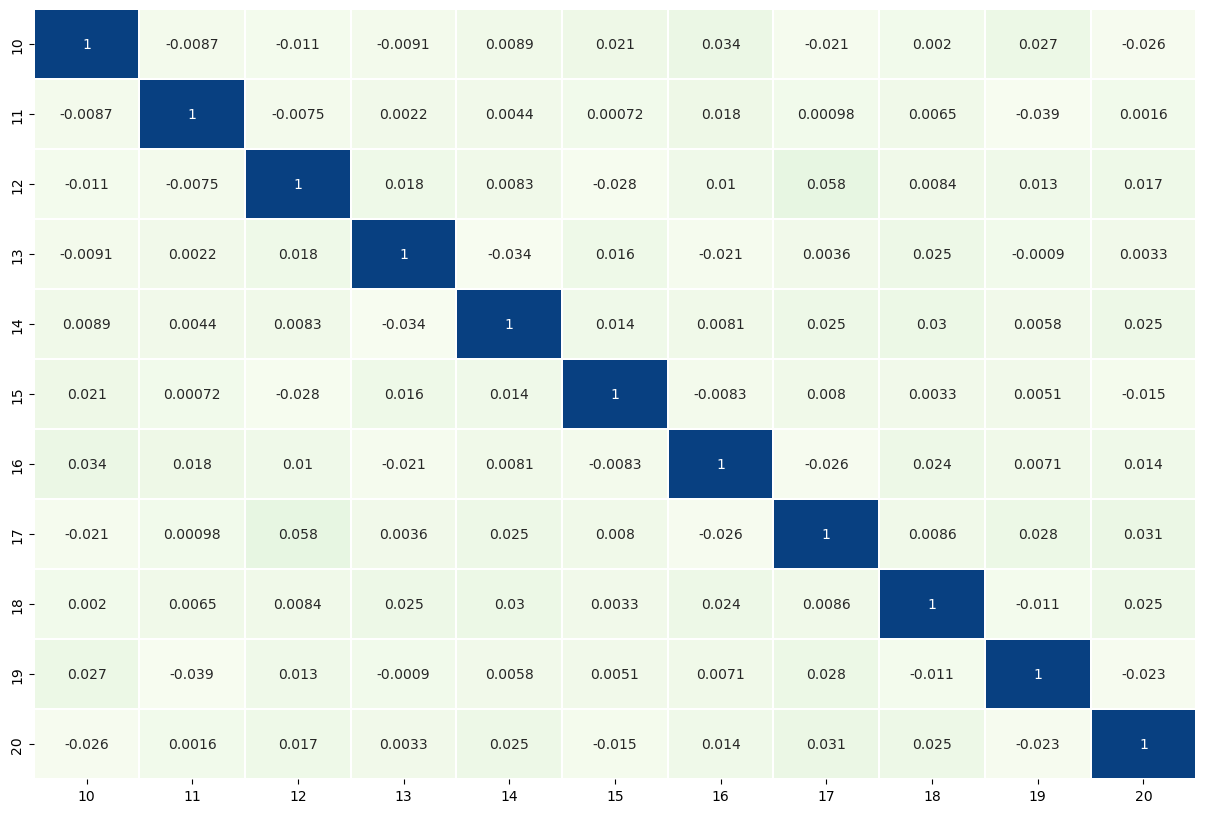

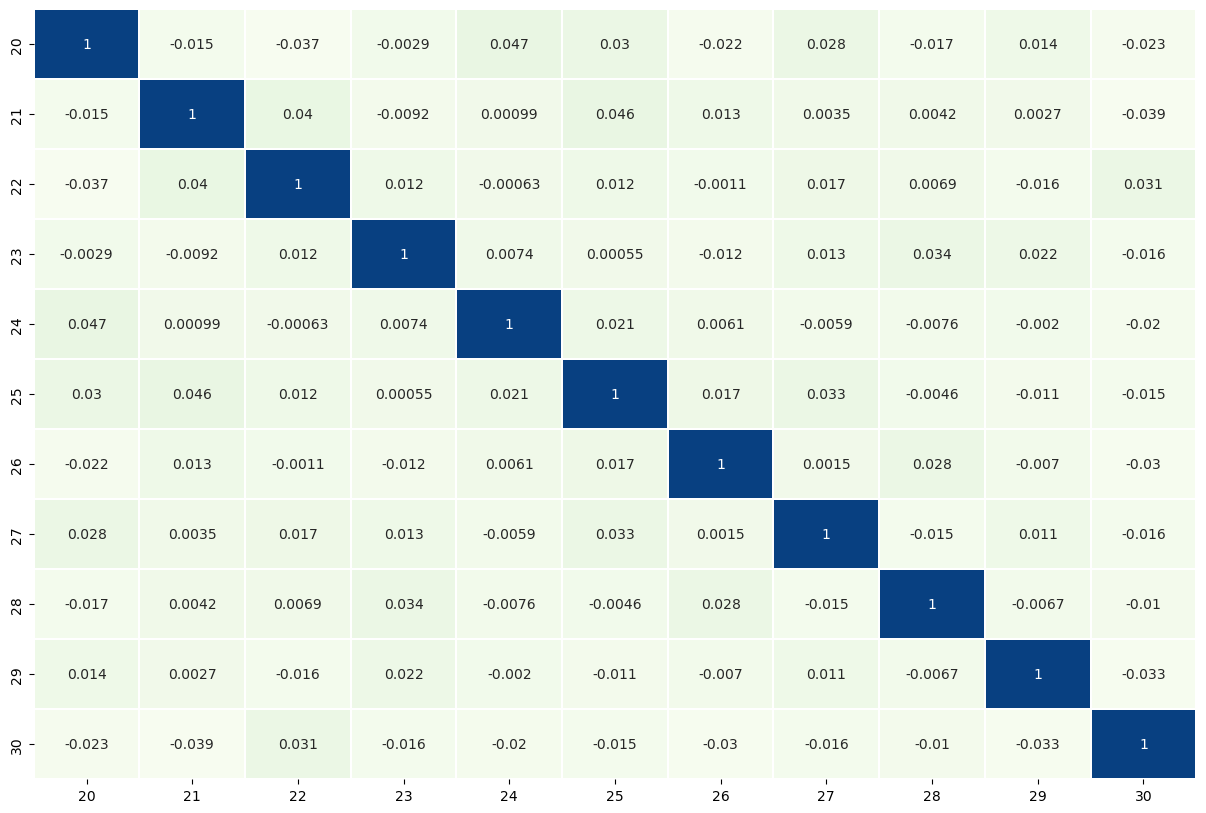

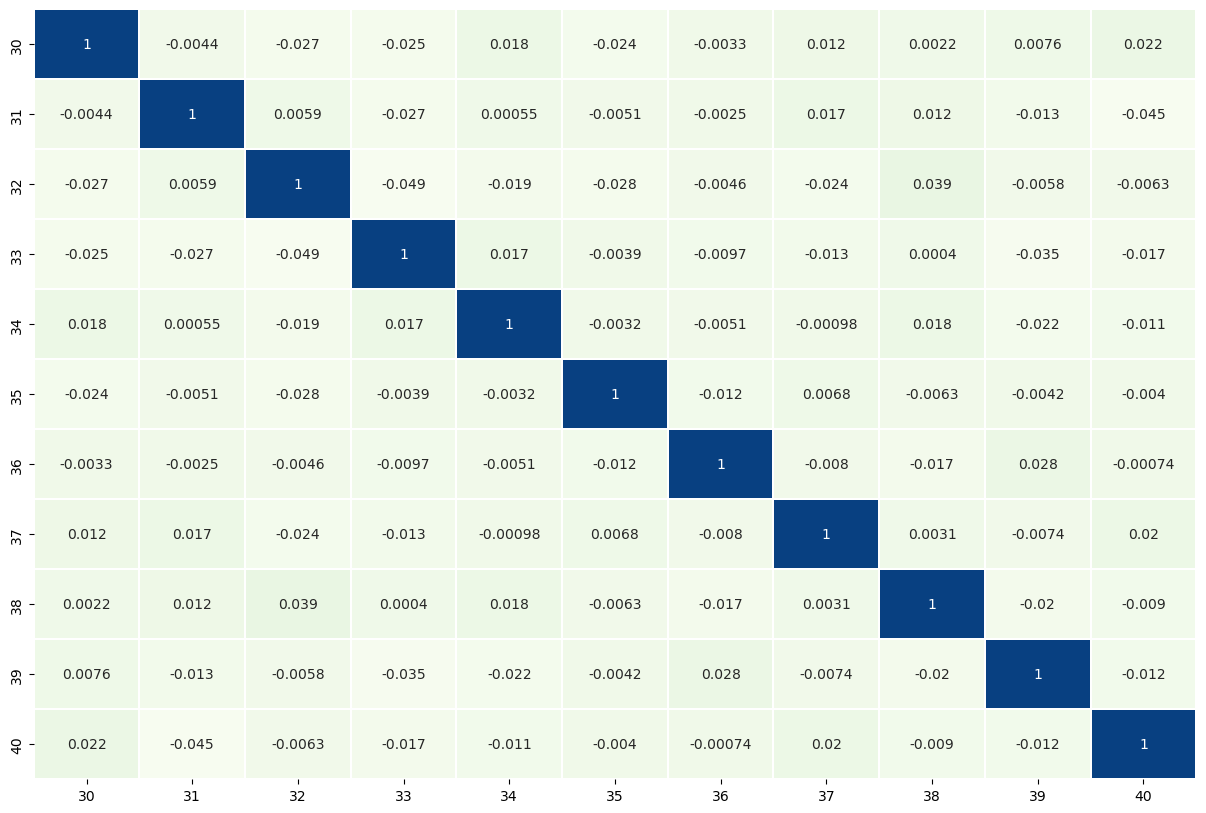

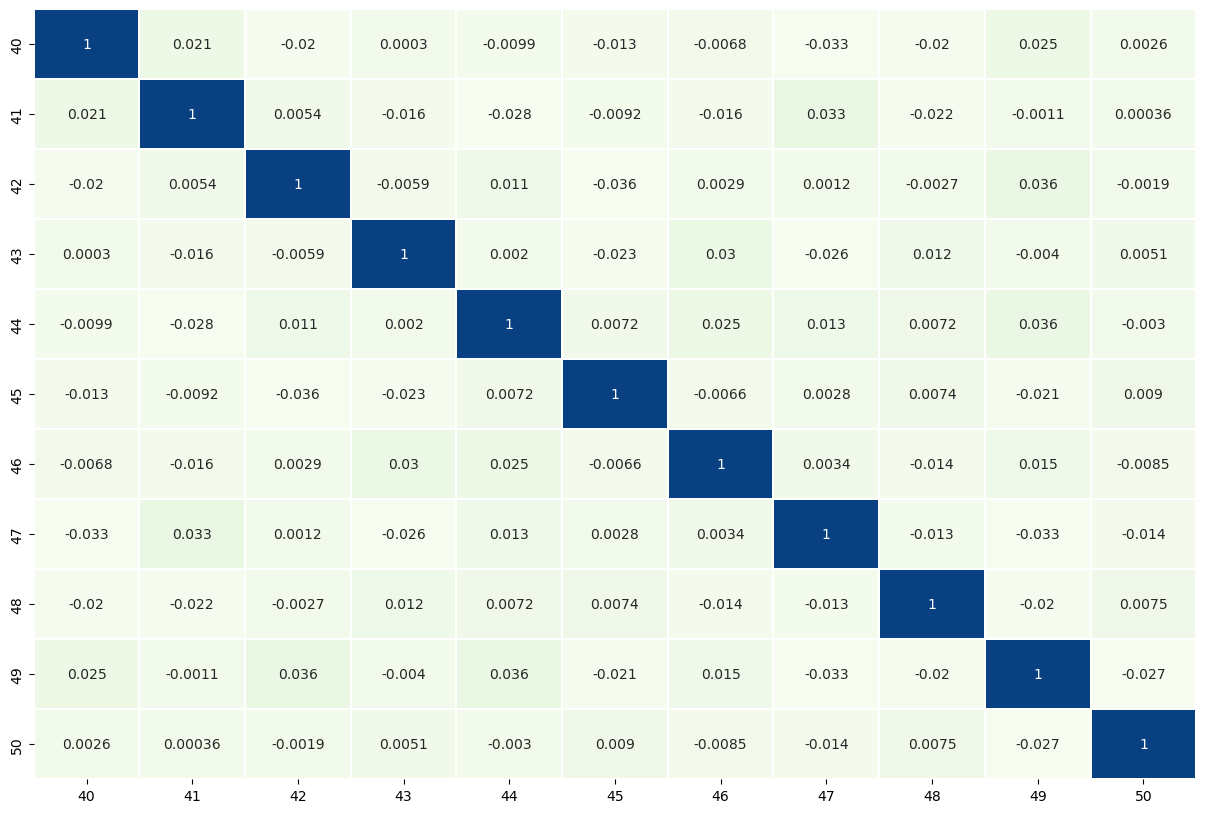

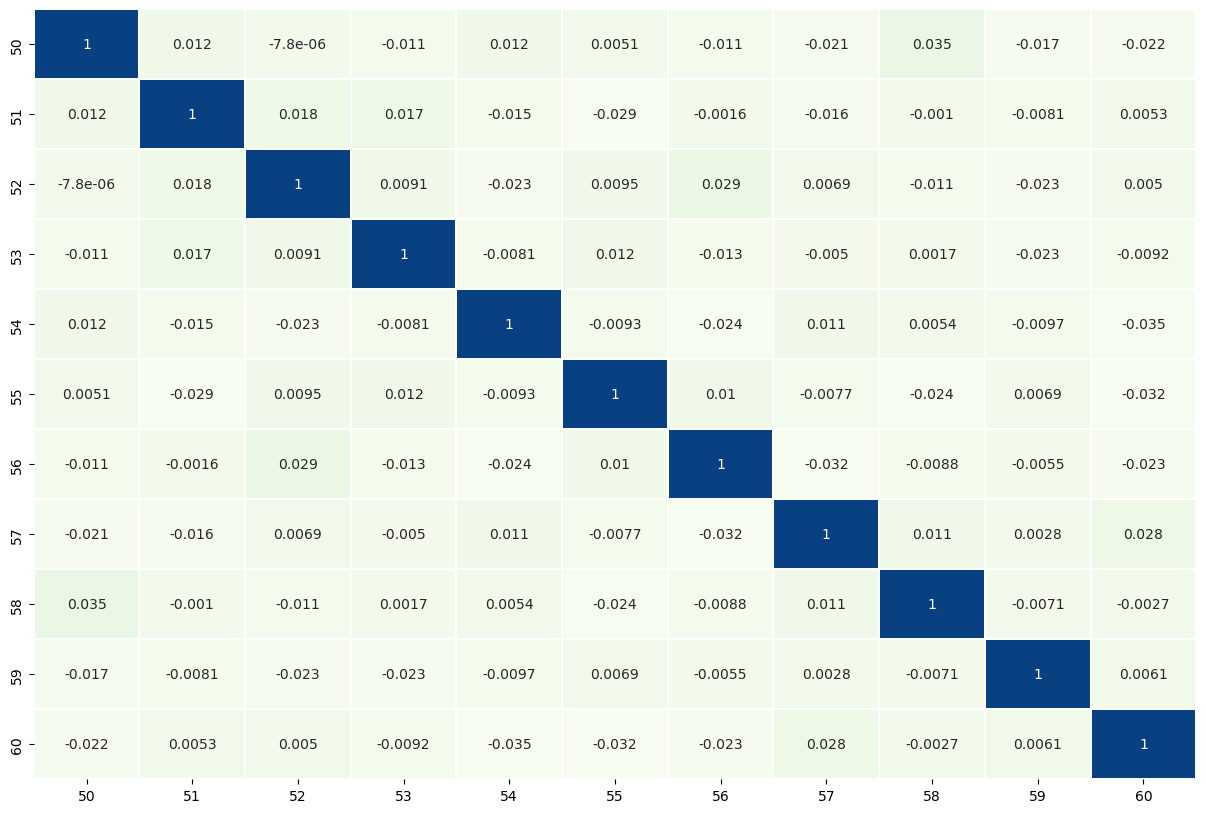

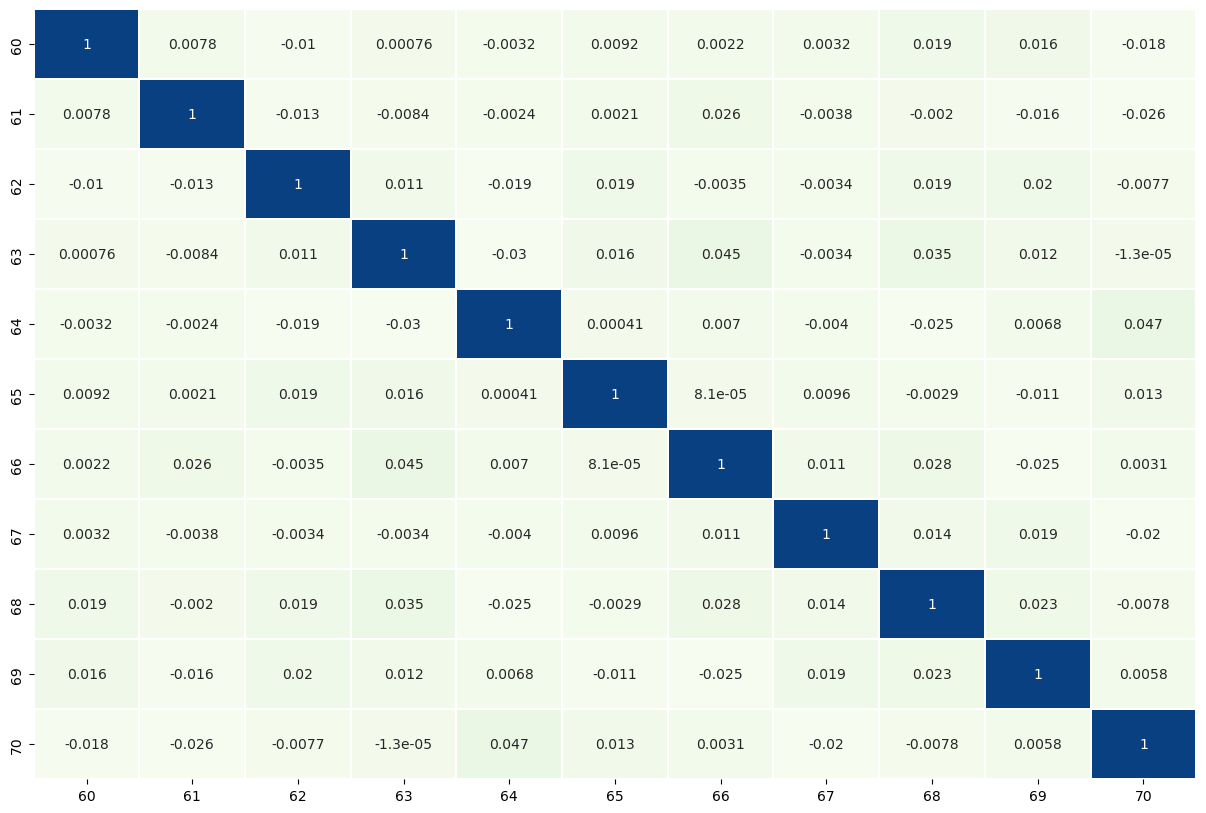

<Figure size 1500x1000 with 0 Axes>

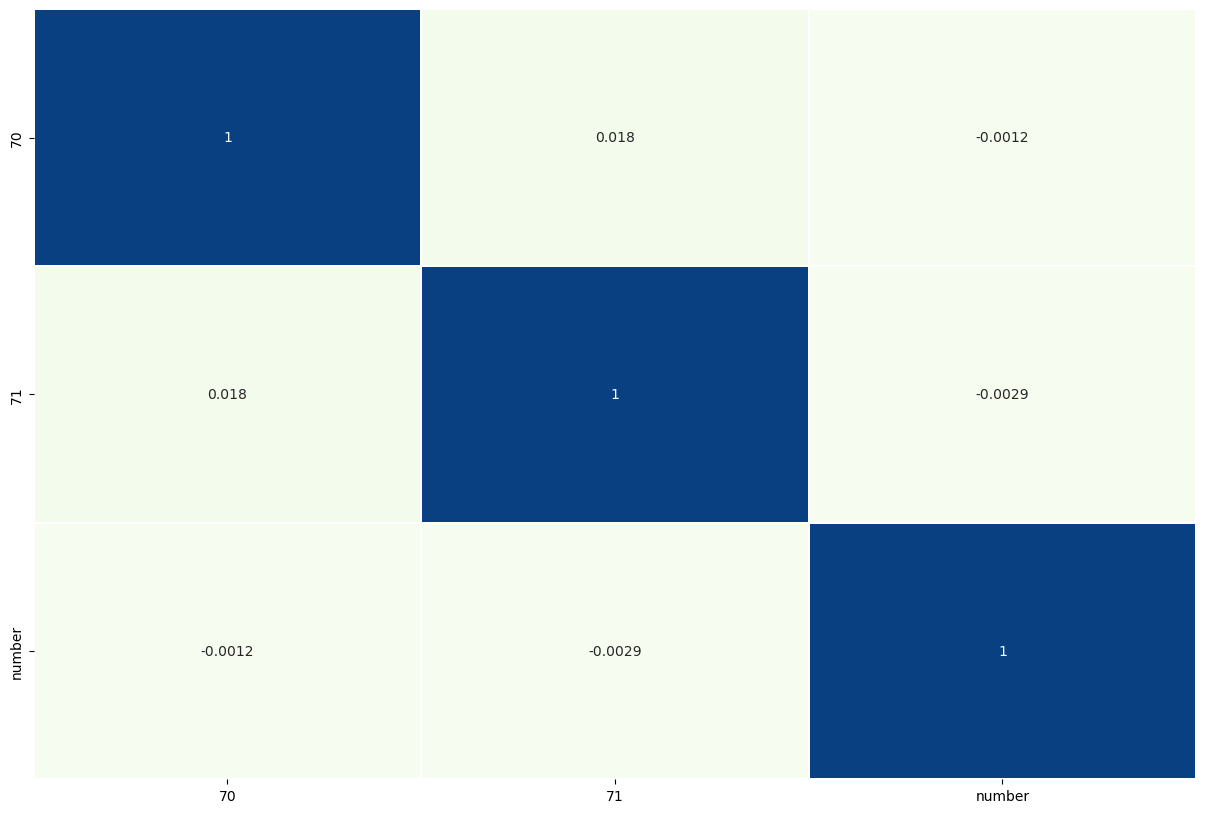

In [38]:
columns = train_v0.columns
columns
k =0

while k < len(columns):
    try:
        plt.figure(figsize=(15, 10)); 
        sns.heatmap(train_v0.loc[:,str(k):str(k+10)][:10000].corr(), annot=True, 
                                             cmap='GnBu', cbar=False, robust=True, linewidths=.2); 
        plt.show()
    except:
        plt.figure(figsize=(15, 10)); 
        sns.heatmap(train_v0.loc[:,str(k):'number'][:10000].corr(), annot=True, 
                                             cmap='GnBu', cbar=False, robust=True, linewidths=.2); 
        plt.show()
    k += 10

interval columns not set, guessing: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']


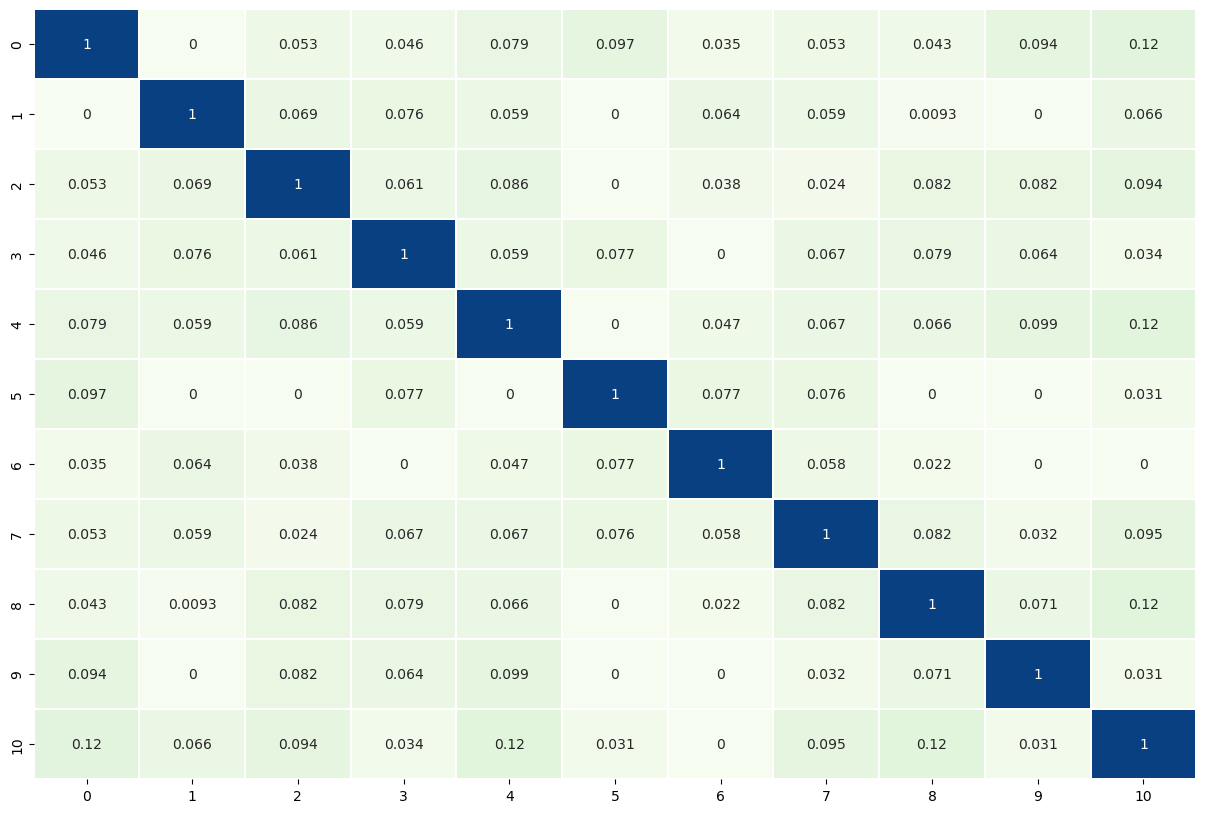

interval columns not set, guessing: ['10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20']


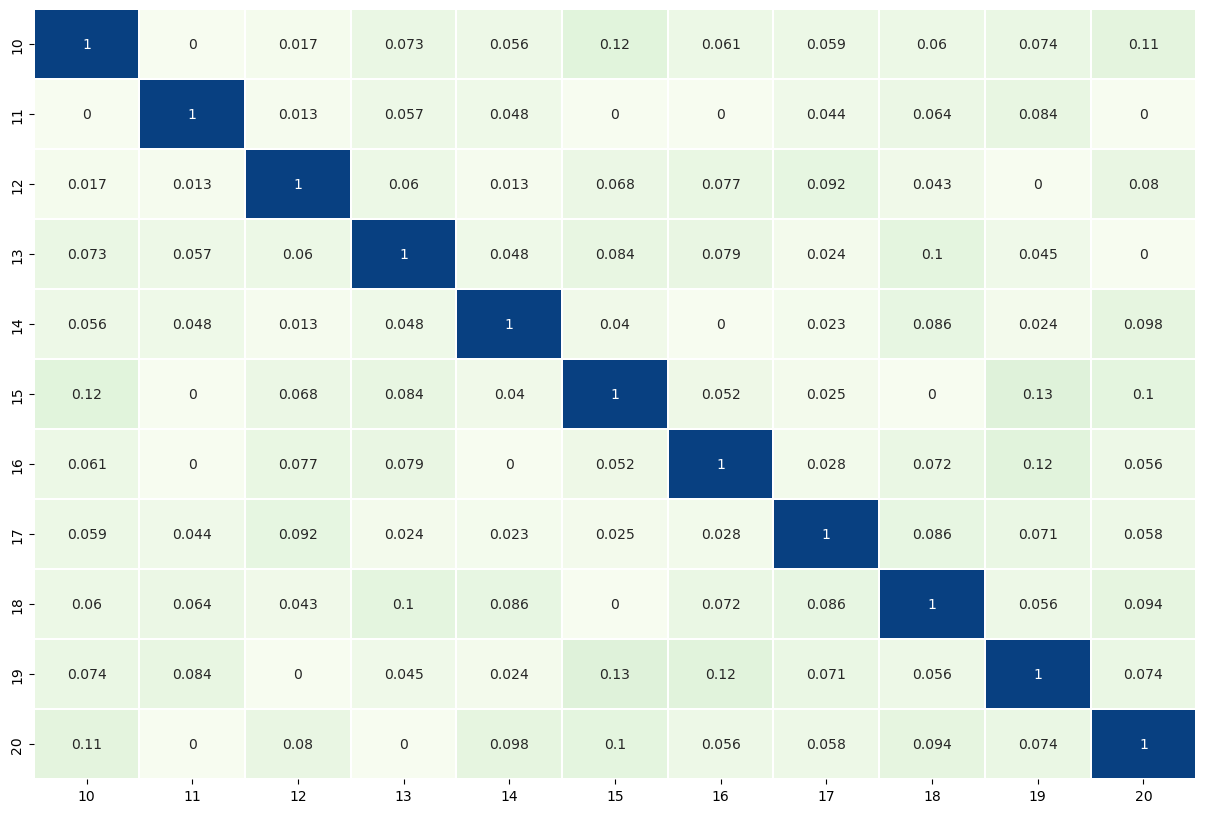

interval columns not set, guessing: ['20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30']


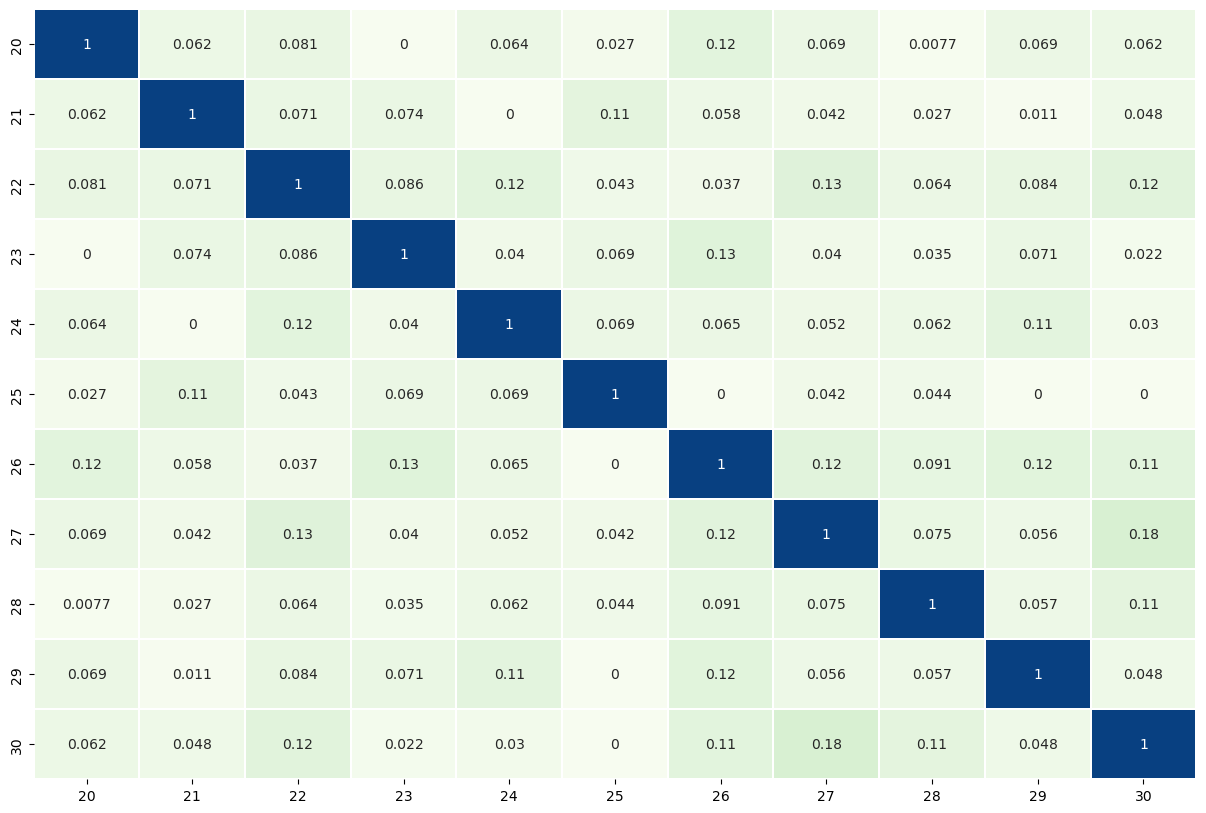

interval columns not set, guessing: ['30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40']


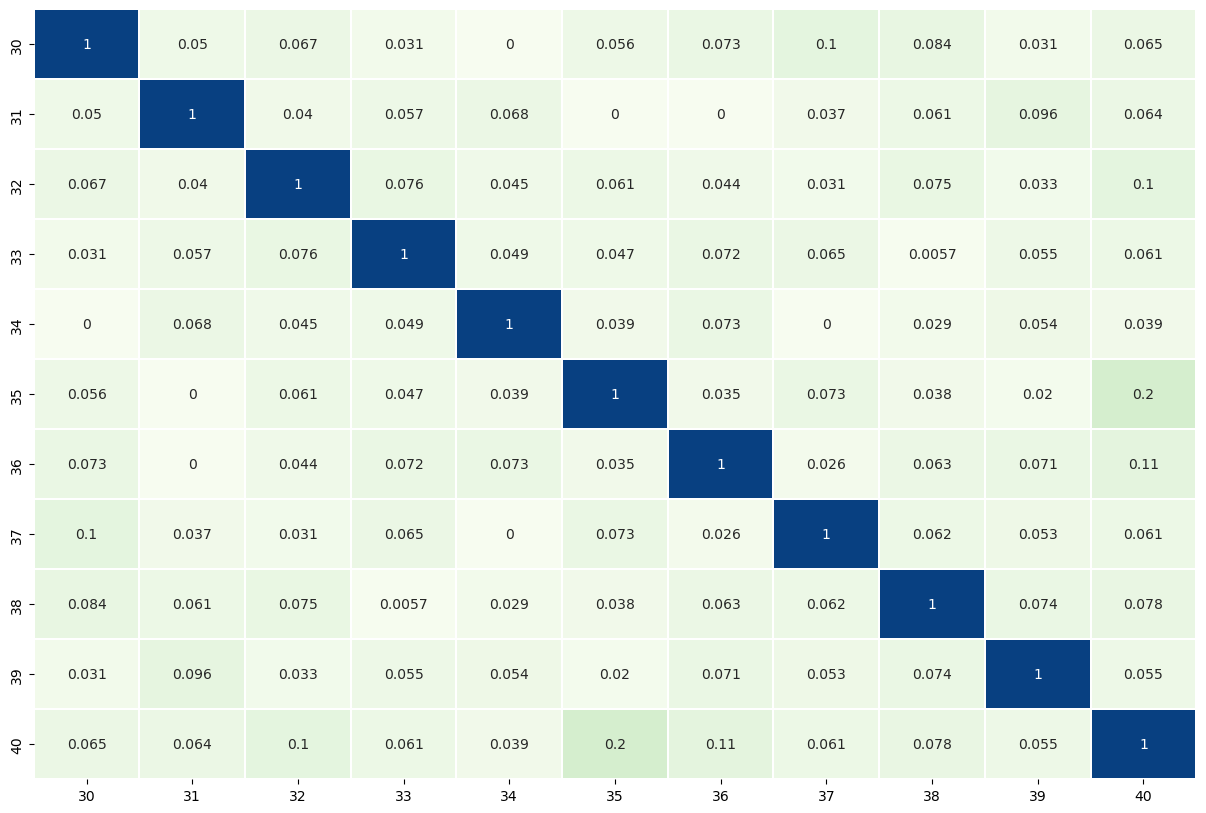

interval columns not set, guessing: ['40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50']


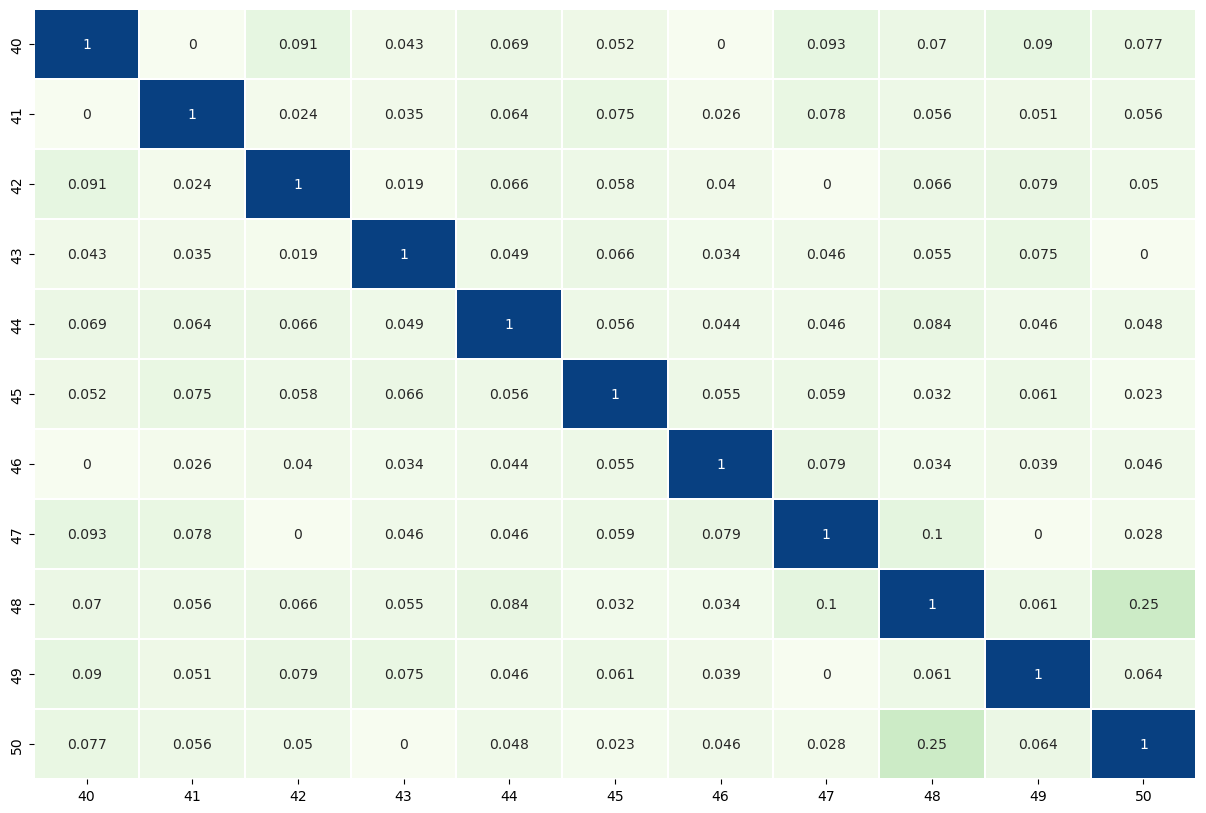

interval columns not set, guessing: ['50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60']


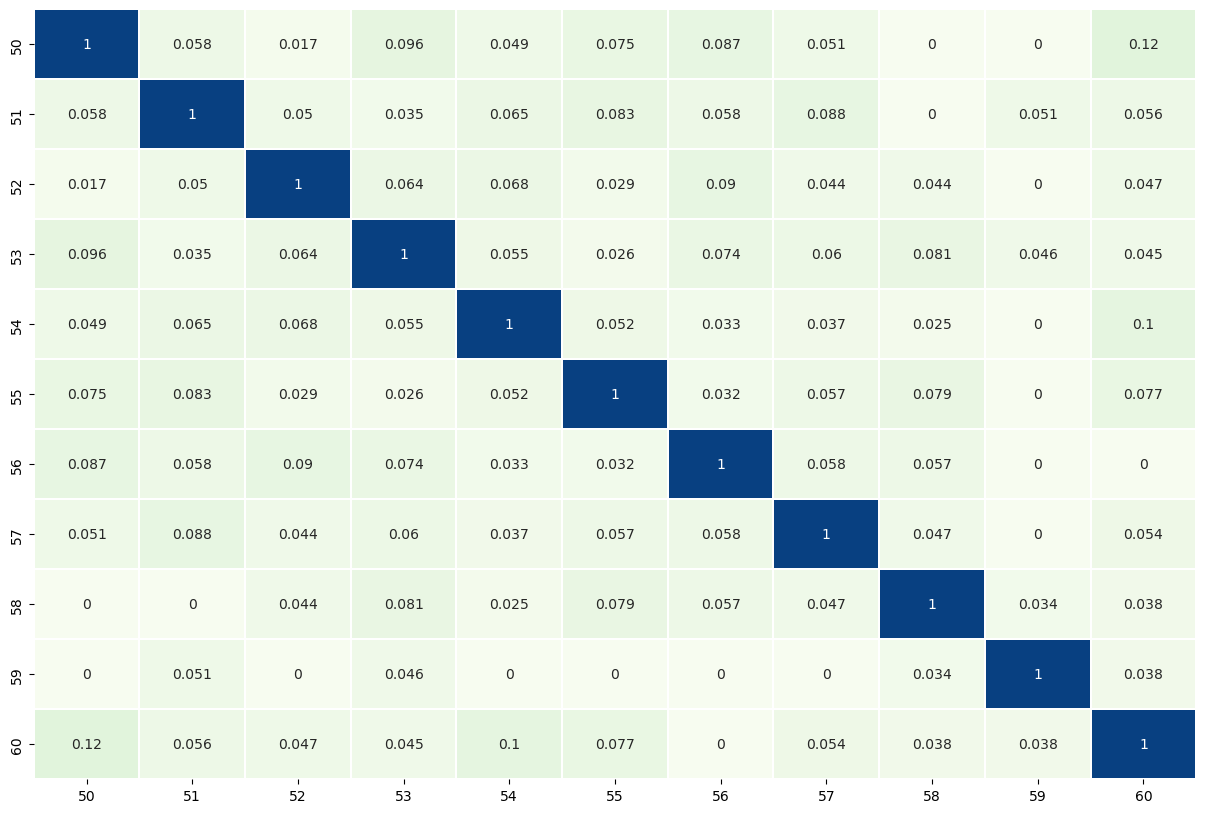

interval columns not set, guessing: ['60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70']


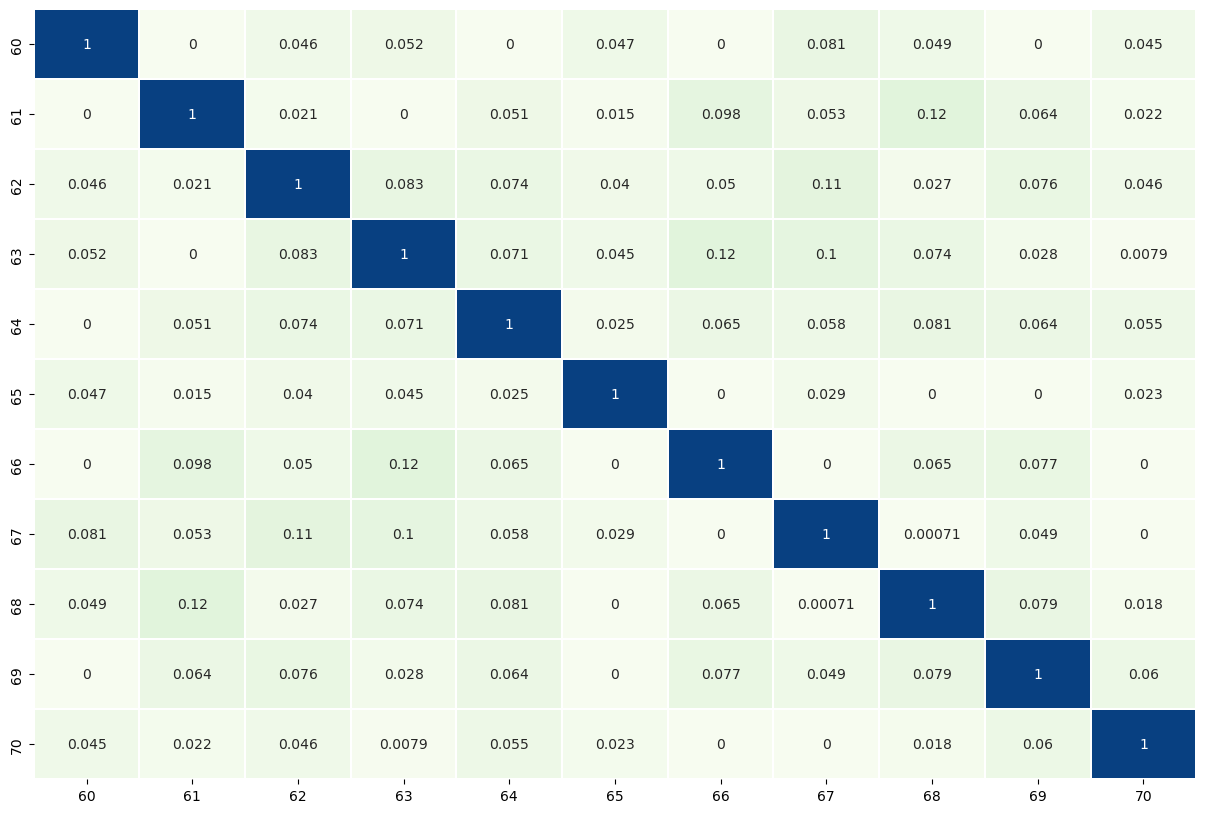

interval columns not set, guessing: ['70', '71', 'number']


D:\Anaconda\lib\site-packages\phik\data_quality.py:59: UserWarning: The number of unique values of variable Target is large: 9900. Are you sure this is not an interval variable? Analysis for pairs of variables including Target can be slow.
  warnings.warn(


<Figure size 1500x1000 with 0 Axes>

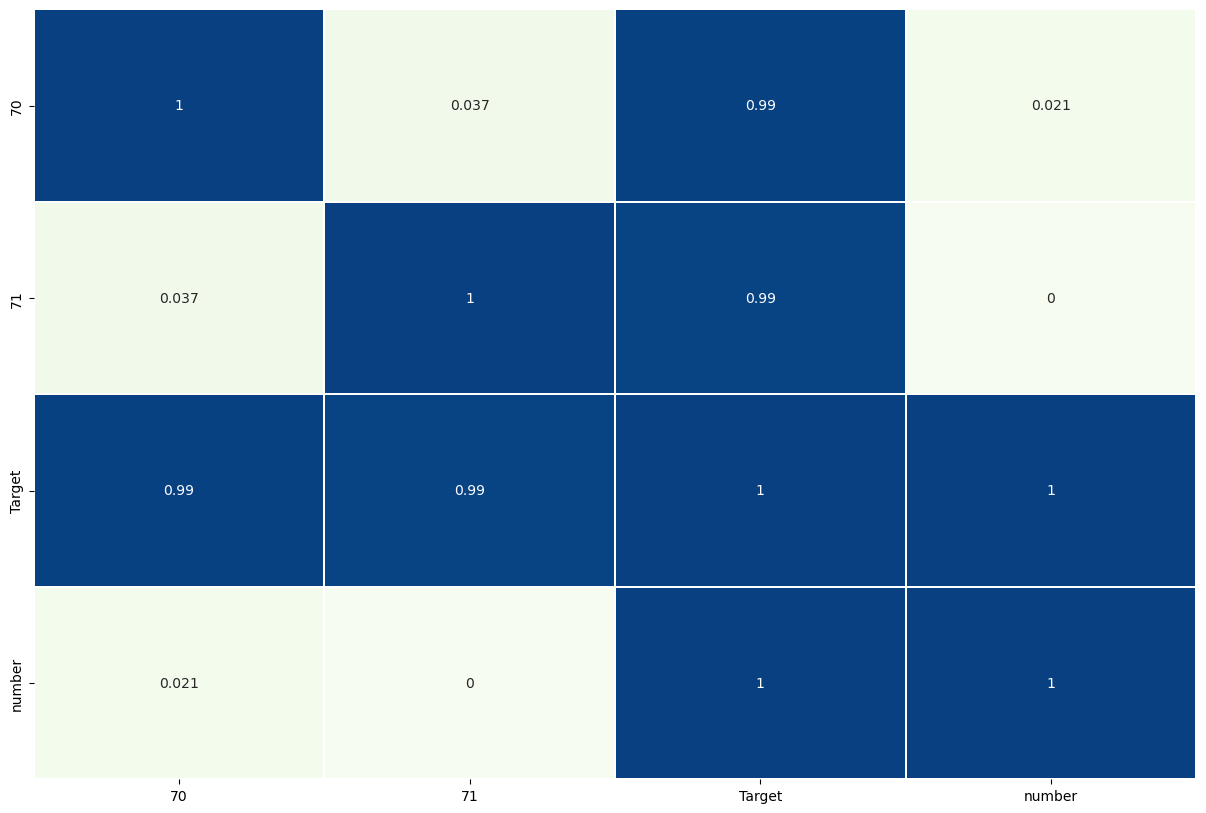

In [39]:
k = 0
while k < len(columns):
    try:
        plt.figure(figsize=(15, 10)); 
        sns.heatmap(train_v0.loc[:,str(k):str(k+10)][:10000].phik_matrix(), annot=True, 
                                                 cmap='GnBu', cbar=False, robust=True, linewidths=.2); 
        plt.show()
    except:
        plt.figure(figsize=(15, 10)); 
        sns.heatmap(train_v0.loc[:,str(k):'number'][:10000].phik_matrix(), annot=True, 
                                                 cmap='GnBu', cbar=False, robust=True, linewidths=.2); 
        plt.show()
    k += 10

Наблюдается высокая корреляция между целевым признаком и признаками 70 и 71. 

Других сильных взаимосвязей признаков не обнаружено.

Ниже проанализируем, какие признаки дают больший вклад в качество модели, а какие ухудшают показатель.

## Нормализация данных

In [40]:
#Из проанализированных методов используем тот, который позволяет достичь наилучший показатель качества 

#scaler = MinMaxScaler() 
#scaler = StandardScaler()

scaler = RobustScaler()

In [41]:
#kNN

base_v0_rs = scaler.fit_transform(base_v0)

train_v0_rs = scaler.transform(df_train_v0)

valid_v0_rs = scaler.transform(valid_v0)


In [42]:
print(base_v0_rs.shape)
print(train_v0_rs.shape)
print(valid_v0_rs.shape)

(10000, 72)
(10000, 72)
(10000, 72)


In [43]:
#FAISS
df_base_rs = scaler.fit_transform(df_base)
df_train_rs = scaler.transform(features_train)

## Визуализация данных с помощью TSNE

Для визуализации данных переведем их в двумерное пространство:

In [44]:
tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(df_train_rs)

D:\Anaconda\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 100000 samples in 0.006s...
[t-SNE] Computed neighbors for 100000 samples in 199.873s...
[t-SNE] Computed conditional probabilities for sample 1000 / 100000
[t-SNE] Computed conditional probabilities for sample 2000 / 100000
[t-SNE] Computed conditional probabilities for sample 3000 / 100000
[t-SNE] Computed conditional probabilities for sample 4000 / 100000
[t-SNE] Computed conditional probabilities for sample 5000 / 100000
[t-SNE] Computed conditional probabilities for sample 6000 / 100000
[t-SNE] Computed conditional probabilities for sample 7000 / 100000
[t-SNE] Computed conditional probabilities for sample 8000 / 100000
[t-SNE] Computed conditional probabilities for sample 9000 / 100000
[t-SNE] Computed conditional probabilities for sample 10000 / 100000
[t-SNE] Computed conditional probabilities for sample 11000 / 100000
[t-SNE] Computed conditional probabilities for sample 12000 / 100000
[t-SNE] Computed conditional proba

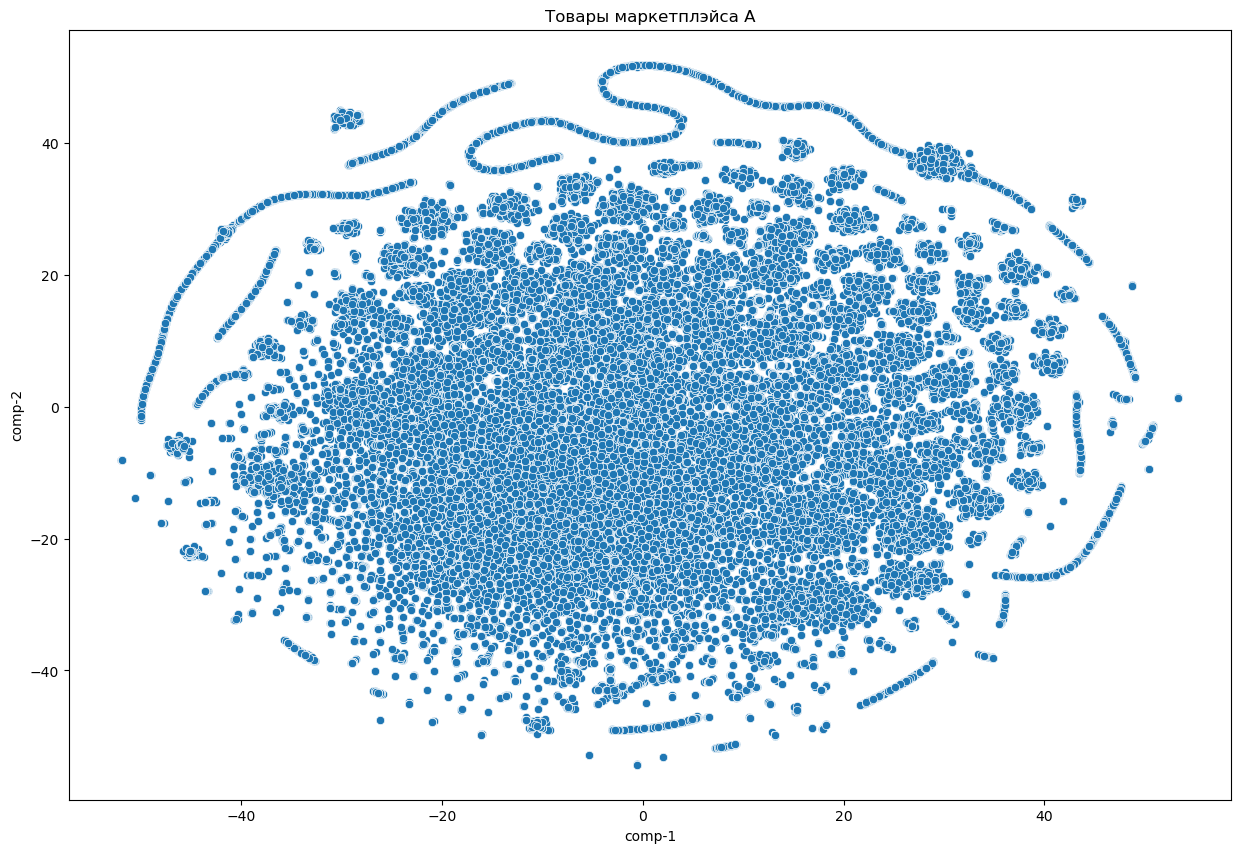

In [45]:
tsne_df = pd.DataFrame()
tsne_df['target'] = targets
tsne_df['comp-1'] = z[:,0]
tsne_df['comp-2'] = z[:,1]

plt.figure(figsize=(15, 10))
sns.scatterplot(x='comp-1', y='comp-2', palette=sns.color_palette("hls", 3), data=tsne_df).set(title='Товары маркетплэйса А');
plt.show()

Наряду с точками данных, сгруппированными в кластеры, на графике отображаются линии, выбивающиеся из общей массы. Требуется доп. обработка данных.

## NearestNeighbors на исходных данных

Попробуем найти наиболее похожие товары методом NearestNeighbors:

In [46]:
nn_model = NearestNeighbors(n_neighbors=5)
nn_model.fit(base_v0)
idx = nn_model.kneighbors(np.array(df_train_v0), return_distance=False)
idx

D:\Anaconda\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


array([[6516, 7484, 1285, 1596, 1074],
       [2133, 4876, 2300, 7749, 7114],
       [8382, 6495,  912, 7274, 4271],
       ...,
       [7736, 4937, 5007, 9830, 3983],
       [ 192, 1009, 8420, 2304, 3282],
       [7894, 9662, 9705, 7516, 9747]], dtype=int64)

In [47]:
acc = 0
for target, el in zip(train_v0['number'].tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])

print(100 * acc / len(idx))

0.0


## NearestNeighbors на масштабированных данных

Рассмотри, влияет ли нормализация на качество модели:

In [48]:
nn_model = NearestNeighbors(n_neighbors=5)
nn_model.fit(base_v0_rs)
idx = nn_model.kneighbors(np.array(train_v0_rs), return_distance=False)
idx

array([[4877, 8887,  570, 4183, 8989],
       [2133, 3631, 1501, 7251, 7954],
       [7985, 8105, 8229, 3270, 1632],
       ...,
       [ 806, 7820, 6872, 6930, 6876],
       [2252, 2052,  192, 4316, 5528],
       [1072, 2141, 7894, 8924, 9662]], dtype=int64)

In [49]:
acc = 0
for target, el in zip(train_v0['number'].tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])

print(100 * acc / len(idx))

0.0


Не влияет.

## FAISS на исходных данных

Рассмотрим методы библиотеки FAISS на исходных данных:

In [58]:
vector_dimension = df_base.shape[1]
n_cells = 333

quantizer = faiss.IndexFlatL2(vector_dimension)
idx_l2 = faiss.IndexIVFFlat(quantizer, vector_dimension, n_cells)

In [60]:
idx_l2.train(np.ascontiguousarray(df_base).astype('float32'))
idx_l2.add(np.ascontiguousarray(df_base).astype('float32'))

In [62]:
vecs, idx = idx_l2.search(np.ascontiguousarray(features_train).astype('float32'), k)

acc = 0
for target, el in zip(targets.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])

print(100 * acc / len(idx))

5.948


Качество не высокое - требуется дополнительная работа с признаками, а также подбор гипрепараметров.
Тем не менее, результат выше, чем у NearestNeighbors, поэтому дальше работу продолжим с этой моделью.

## FAISS на масштабированных данных

Стандартизация данных может помочь точнее группировать товары и выявлять соседей, проверим качество на масштабированных данных:

In [63]:
dims = pd.DataFrame(df_base_rs).shape[1]
n_cells = 10
quantizer2 = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer2, dims, n_cells)

In [64]:
idx_l2.train(np.ascontiguousarray(df_base_rs[:10000, :]).astype('float32'))
idx_l2.add(np.ascontiguousarray(df_base_rs).astype('float32'))

In [65]:
vecs, idx = idx_l2.search(np.ascontiguousarray(df_train_rs).astype('float32'), k)

acc_rs = 0
for target, el in zip(targets.values.tolist(), idx.tolist()):
    acc_rs += int(target in [base_index[r] for r in el])

print(100 * acc_rs / len(idx))

51.452


На всех данных:

In [66]:
dims = pd.DataFrame(df_base_rs).shape[1]
n_cells = 10
# how many cells
quantizer2 = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer2, dims, n_cells)

In [67]:
idx_l2.train(np.ascontiguousarray(df_base_rs).astype('float32'))
idx_l2.add(np.ascontiguousarray(df_base_rs).astype('float32'))

In [68]:
vecs, idx_rs = idx_l2.search(np.ascontiguousarray(df_train_rs).astype('float32'), k)

acc = 0
for target, el in zip(targets.values.tolist(), idx_rs.tolist()):
    acc += int(target in [base_index[r] for r in el])

print(100 * acc / len(idx_rs))

62.296


Таким образом, подбор метода масштабирование данных позволяет достичь существенного повышения метрики.

## Отбор признаков на основе распределения данных

На гистограммах видно, что некоторые признаки представляют собой околопостоянные величины с выбросами, данные с большим количеством шумов и пр. Рассмотрим как повлияет на качество модели удаление признаков, не распределенных нормально:

In [71]:
columns_to_test = ['6','21','25','33','41','44','65','70']

In [72]:
columns_to_del = []

for feature in columns_to_test:
    df_base_norm = df_base.drop(columns=feature)
    df_train_norm = features_train.drop(columns=feature)
    
    df_base_norm_rs = scaler.fit_transform(df_base_norm)
    df_train_norm_rs = scaler.transform(df_train_norm)
    
    dims = pd.DataFrame(df_base_norm_rs).shape[1]
    n_cells = 10
    quantizer2 = faiss.IndexFlatL2(dims)
    idx_l2 = faiss.IndexIVFFlat(quantizer2, dims, n_cells)
    
    idx_l2.train(np.ascontiguousarray(df_base_norm_rs[:10000, :]).astype('float32'))
    idx_l2.add(np.ascontiguousarray(df_base_norm_rs).astype('float32'))

    vecs, idx = idx_l2.search(np.ascontiguousarray(df_train_norm_rs).astype('float32'), k)
    acc2 = 0
    for target, el in zip(targets.values.tolist(), idx.tolist()):
        acc2 += int(target in [base_index[r] for r in el])
        
    print(100 * acc2 / len(idx))
    print(feature)
    
    if (100 * acc2 / len(idx)) > ((100 * acc / len(idx_rs)) +1):
        columns_to_del.append(feature)
    

48.74
6
57.093
21
59.234
25
50.413
33
52.453
41
49.511
44
50.169
65
52.147
70


Дальше будем работать с данными без этих признаков:

In [73]:
columns_to_del = ['6','21','25','44','65','70']

In [74]:
df_base_norm = df_base.drop(columns=columns_to_del)
df_train_norm = features_train.drop(columns=columns_to_del)

In [75]:
df_base_norm_rs = pd.DataFrame(scaler.fit_transform(df_base_norm), columns = df_base_norm.columns, 
                                 index = df_base_norm.index)

df_train_norm_rs = pd.DataFrame(scaler.transform(df_train_norm), columns = df_train_norm.columns, 
                                 index = df_train_norm.index)

In [76]:
df_base_norm_rs_np = scaler.fit_transform(df_base_norm)

df_train_norm_rs_np = scaler.transform(df_train_norm)

In [77]:
tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(df_train_norm_rs)

D:\Anaconda\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
D:\Anaconda\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 100000 samples in 0.000s...
[t-SNE] Computed neighbors for 100000 samples in 208.152s...
[t-SNE] Computed conditional probabilities for sample 1000 / 100000
[t-SNE] Computed conditional probabilities for sample 2000 / 100000
[t-SNE] Computed conditional probabilities for sample 3000 / 100000
[t-SNE] Computed conditional probabilities for sample 4000 / 100000
[t-SNE] Computed conditional probabilities for sample 5000 / 100000
[t-SNE] Computed conditional probabilities for sample 6000 / 100000
[t-SNE] Computed conditional probabilities for sample 7000 / 100000
[t-SNE] Computed conditional probabilities for sample 8000 / 100000
[t-SNE] Computed conditional probabilities for sample 9000 / 100000
[t-SNE] Computed conditional probabilities for sample 10000 / 100000
[t-SNE] Computed conditional probabilities for sample 11000 / 100000
[t-SNE] Computed conditional probabilities for sample 12000 / 100000
[t-SNE] Computed conditional proba

In [78]:
tsne_df = pd.DataFrame()
tsne_df['target'] = targets
tsne_df['comp-1'] = z[:,0]
tsne_df['comp-2'] = z[:,1]

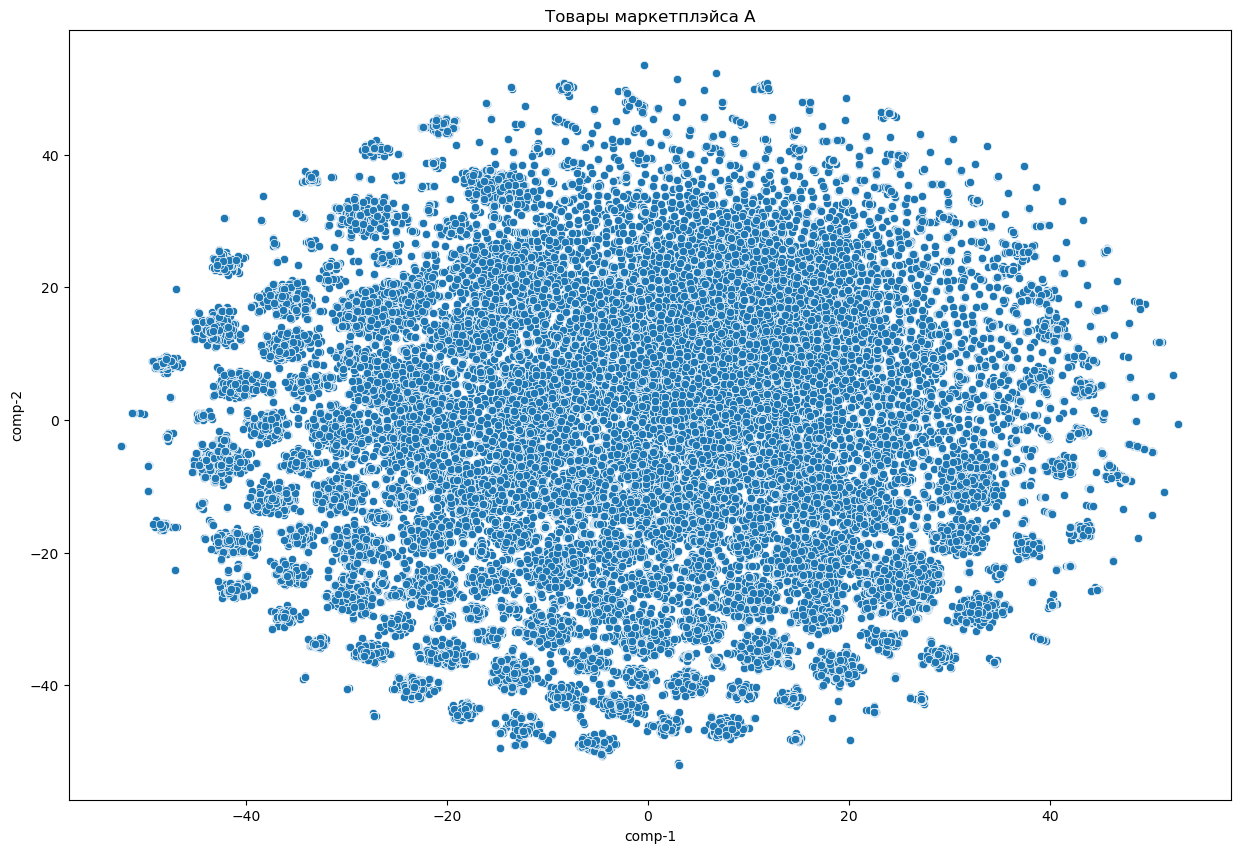

In [79]:
plt.figure(figsize=(15, 10))
sns.scatterplot(x='comp-1', y='comp-2', palette=sns.color_palette("hls", 3), data=tsne_df).set(title='Товары маркетплэйса А');
plt.show()

Удаление признаков позволило добиться более упорядоченной структуры данных, в которых прослеживается возможность группировки по кластерам.

In [80]:
dims = pd.DataFrame(df_base_norm_rs_np).shape[1]
n_cells = 10
quantizer2 = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer2, dims, n_cells)

In [81]:
idx_l2.train(np.ascontiguousarray(df_base_norm_rs_np[:10000, :]).astype('float32'))
idx_l2.add(np.ascontiguousarray(df_base_norm_rs_np).astype('float32'))

In [82]:
vecs, idx = idx_l2.search(np.ascontiguousarray(df_train_norm_rs_np).astype('float32'), k)

In [83]:
acc = 0
for target, el in zip(targets.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])

In [84]:
print(100 * acc / len(idx))

68.334


На всех данных

In [85]:
dims = pd.DataFrame(df_base_norm_rs_np).shape[1]
n_cells = 10
# how many cells
quantizer2 = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer2, dims, n_cells)

In [86]:
idx_l2.train(np.ascontiguousarray(df_base_norm_rs_np).astype('float32'))
idx_l2.add(np.ascontiguousarray(df_base_norm_rs_np).astype('float32'))

In [87]:
vecs, idx = idx_l2.search(np.ascontiguousarray(df_train_norm_rs_np).astype('float32'), k)

In [88]:
acc = 0
for target, el in zip(targets.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])

In [89]:
print(100 * acc / len(idx))

66.848


Избавление от признаков, распределение которых отклоняется от нормального, также позволило улучшить качество модели.

## Кластеризация методом kMeans

В качестве метода кластеризации попробуем kMeans:

In [90]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(base_v0_rs)

KMeans(n_clusters=2)

In [91]:
kmeans.inertia_

51854560.0

Оптимальное количество кластеров подберем с помощью "метода локтя":

Text(0, 0.5, 'Inertia')

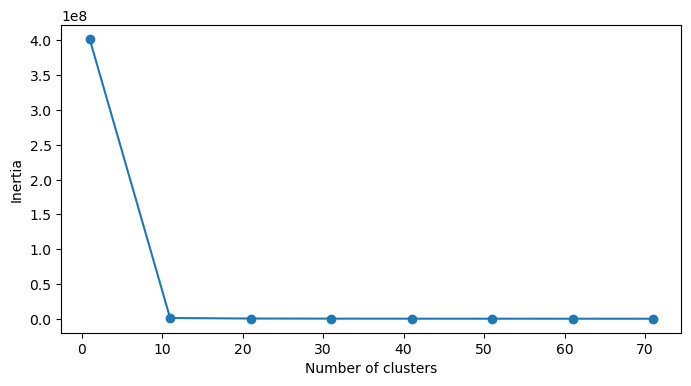

In [92]:
in_list = []
for cluster in range(1,72,10):
    kmeans = KMeans(n_clusters = cluster, init='k-means++')
    kmeans.fit(base_v0_rs)
    in_list.append(kmeans.inertia_)

results = pd.DataFrame({'cluster':range(1,72,10), 'inertia':in_list})
plt.figure(figsize=(8,4))
plt.plot(results['cluster'], results['inertia'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia');

Рассмотрим диапазон от 3 до 12 кластеров укрупненно:

Text(0, 0.5, 'Inertia')

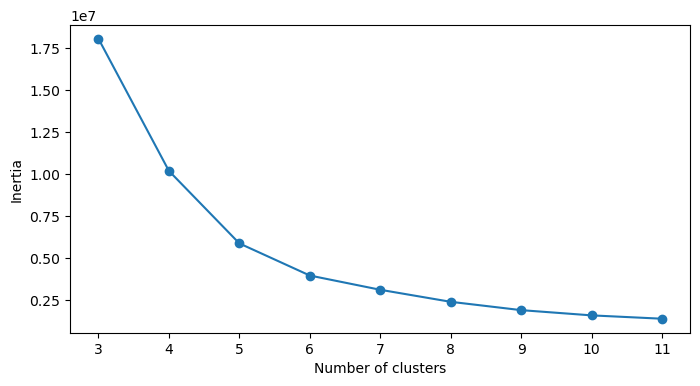

In [93]:
in_list = []
for cluster in range(3,12):
    kmeans = KMeans(n_clusters = cluster, init='k-means++')
    kmeans.fit(base_v0_rs)
    in_list.append(kmeans.inertia_)

results = pd.DataFrame({'cluster':range(3,12), 'inertia':in_list})
plt.figure(figsize=(8,4))
plt.plot(results['cluster'], results['inertia'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia');

In [94]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(base_v0_rs)
kmeans.inertia_

5855053.0

In [95]:
predictions = kmeans.predict(base_v0_rs)
predictions[:72]

array([0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 2, 0, 3, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 4,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0,
       1, 0, 0, 0, 0, 1])

Добавим номера кластеров к данным, чтобы использовать их для дальнейшей классификации:

In [96]:
base_v0_k_means = pd.DataFrame(base_v0_rs) 
base_v0_k_means['preds'] = predictions
base_v0_k_means['preds'].value_counts()

0    8353
2     490
4     405
1     391
3     361
Name: preds, dtype: int64

In [97]:
kmeans.labels_

array([0, 0, 0, ..., 0, 0, 0])

In [98]:
base_v0_k_means.head() 

0         1         2         3         4         5         6  \
0    -0.826834  0.503708 -0.414845  1.026327  1.642428 -0.840265 -0.001300   
1     1.462973  0.828511 -0.521581 -0.743861 -0.850871 -0.362973  0.771703   
2     0.903571 -0.207562  0.286332  0.486460  0.612673 -0.705217  1.048764   
3    -0.042999 -0.556450 -0.880275 -1.432364 -0.557442  0.332788  0.171597   
4     0.377196 -0.186303  1.737428  0.219211 -1.665118 -1.029544  0.142351   
...        ...       ...       ...       ...       ...       ...       ...   
9995  0.638699 -0.638316  0.742312 -0.125671 -0.175153 -0.614682 -0.026231   
9996 -0.197322 -0.107400  1.150146  0.578732  1.817735 -0.003570 -0.127191   
9997 -0.929028 -0.406464 -0.702554  0.784428  0.411820 -0.745495  0.718571   
9998  0.447601  0.609597  0.574300  0.369761  1.229983  0.068835 -0.282032   
9999 -0.141539  0.502540  0.456834  0.141808 -0.990509 -0.354646  0.547660   

             7         8         9        10        11        12        13  \
0     0.270719 -0.292056  0.653500  0.317713  0.516862 -0.302714  0.562560   
1    -0.642671 -0.429760  0.814496 -0.000140 -0.832030 -0.518198  0.003373   
2     0.476653  0.632648  0.454153  0.008744  0.659480 -0.194272 -0.112763   
3    -0.619533 -0.163574  0.125401  0.605117 -0.514066 -0.773300 -1.766876   
4     0.280248 -0.148009 -0.156244  0.570609  0.423554 -0.167167 -0.698412   
...        ...       ...       ...       ...       ...       ...       ...   
9995 -0.446337 -0.020691 -0.529363 -0.049245 -0.257453  1.093807  0.382126   
9996 -0.409002 -0.426938 -0.864470  1.767519 -0.356935 -0.062271  0.151717   
9997 -0.330865 -0.306110 -0.488424  0.206844 -0.638721 -0.530192 -0.046003   
9998 -0.296699 -0.301451  0.469863  0.065233 -0.027297 -0.312754  0.716959   
9999 -0.332811 -0.374919  0.816276  0.013864 -0.837664 -1.004306 -0.012454   

            14        15        16        17        18        19        20  \
0     0.719024 -0.284026 -0.143010  0.195687  0.737130 -0.310293 -0.180703   
1    -0.138077  1.833459  0.570149  0.880104 -1.700647 -1.132911  0.416362   
2    -0.192059  0.062613 -0.210215  0.148406  0.410426  0.132417  0.398450   
3    -0.775694 -0.911756 -0.128233  0.333451  0.202181  0.051699 -0.288633   
4    -0.306941  0.897491  0.351894  1.747366  0.107476 -0.157645  1.061758   
...        ...       ...       ...       ...       ...       ...       ...   
9995 -0.145341  0.239849  0.372225 -0.187294 -0.905100 -0.660556 -0.273938   
9996 -0.430688 -0.001445 -0.867967  0.234867 -0.770582  0.421120  1.121944   
9997 -0.462394  0.775640  0.153748  0.307850 -0.670233 -1.414958  0.515430   
9998 -0.826580  1.001140 -0.718632  0.782821 -0.851934 -0.387691 -0.478196   
9999 -1.570318 -0.184843  0.515127  0.016424 -0.101809  0.902432 -0.015551   

            21        22        23        24          25        26        27  \
0     0.000000 -0.386014 -0.116863 -1.445070    0.000000  0.281572 -1.288960   
1    -2.974606 -0.000498  0.281068  0.744452    0.000000  0.836461  0.120504   
2     0.000000  0.079293  0.577798  0.684719    0.000000 -0.507359  0.391355   
3    -0.077477 -1.726513 -0.685404 -0.798569    0.000000 -1.467509 -0.274169   
4    -0.674553  0.363461  0.061562  0.921540 -501.071167 -0.154329  0.787095   
...        ...       ...       ...       ...         ...       ...       ...   
9995  0.000000 -0.581830 -0.993738 -0.818319    0.000000  0.472187 -0.424985   
9996  0.000000  1.649263 -1.801565 -0.632132    0.000000 -0.540001 -0.964999   
9997  0.000000 -0.515239 -0.081470  1.168922    0.000000  1.310855  0.203645   
9998  0.000000  0.046183 -0.420798  1.348727    0.000000  0.789653 -0.042836   
9999 -3.548121  0.279666 -1.954896 -0.794650    0.000000 -0.145605 -0.639790   

            28        29        30        31        32        33        34  \
0    -0.681377 -0.219335  0.048345  0.026273 -0.208849 -0.017983 -0.621688   
1     0.709664 -0.263875  0.112875 -0.668722  0.358866  0.513728 -0.358727   
2    -0

Таким образом, товары были разбиты на 5 кластеров. Рассмотрим, какие признаки повлияли на разбиение:

## RandomForest

In [99]:
rf_features = base_v0_k_means.drop('preds', axis=1)
rf_target = base_v0_k_means['preds']

In [100]:
model = RandomForestClassifier(random_state=SEED)
model.fit(rf_features, rf_target)

RandomForestClassifier(random_state=123)

Наиболее важные признаки для кластеризации k means:

In [101]:
importances_df = pd.DataFrame({
    'feature': rf_features.columns.astype('str'),
    'importance': model.feature_importances_
}).sort_values(by='importance', ascending=False)

importances_df.head(20)

feature  importance
25      25    0.568756
33      33    0.015092
44      44    0.011976
28      28    0.008475
22      22    0.007924
9        9    0.007636
6        6    0.007608
68      68    0.006909
67      67    0.006728
10      10    0.006478
17      17    0.006347
70      70    0.006292
46      46    0.006286
35      35    0.006232
45      45    0.006194
19      19    0.006191
31      31    0.006191
48      48    0.006179
63      63    0.006136
55      55    0.006072

## Отбор признаков по кластеризации kMeans

Рассчитаем модель с 20 наиболее важными с т.з. k means признаками:

In [102]:
df_base_red = df_base[importances_df.sort_values(by='importance', ascending=False).head(20)['feature'].unique()]
df_base_red.head()

25          33         44          28          22           9  \
Id                                                                              
0-base  813.770081 -537.183716 -57.470089 -129.976639  -32.591667  181.449707   
1-base  813.770081 -303.939240 -31.948471  -39.418385   -5.937690  195.234192   
2-base  813.770081 -780.449158 -46.745781  -94.789474   -0.421011  164.381470   
3-base  813.770081 -529.295044 -17.321358  -62.932701 -125.271614  136.233582   
4-base  312.698914 -657.524414 -32.975979  -24.069107   19.225910  112.119064   

                 6          68         67          10          17  \
Id                                                                  
0-base -469.070587   92.933609  -4.703861 -124.061508   -1.732183   
1-base  -85.076668  179.937927  24.346846 -141.304352   48.246361   
2-base   52.554794   81.073486  66.325684 -140.822449   -5.184787   
3-base -383.182831  137.206940 -20.566910 -108.470444    8.327808   
4-base -397.711273   65.315285  -2.505783 -110.342453  111.576950   

                 70          46          35          45         19  \
Id                                                                   
0-base  -112.756638  -98.871155  111.518677   17.266476 -79.466667   
1-base   -84.888939 -166.473358   53.394676   62.484821 -80.279419   
2-base -1074.464844  -10.286392   79.781555   65.927475 -79.029266   
3-base -1074.464844  -94.379646   92.806305  105.217239 -79.109016   
4-base -1074.464844   30.838631   71.061523   66.864883 -79.315849   

                31         48         63         55  
Id                                                   
0-base -143.005035  91.000381  38.800827  79.812180  
1-base -174.369949 -56.731556  41.099998  74.832840  
2-base -144.845367  21.048609  46.011803  69.979630  
3-base -134.934341  29.217487  -6.358921  72.636101  
4-base -148.131851  57.695343  56.642403  58.086998

In [103]:
df_train_red = df_train[importances_df.sort_values(by='importance', ascending=False).head(20)['feature'].unique()]

In [104]:
df_base_red_rs = scaler.fit_transform(df_base_red)
df_train_red_rs = scaler.transform(df_train_red)

In [105]:
dims = pd.DataFrame(df_base_red_rs).shape[1]
n_cells = 10
quantizer2 = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer2, dims, n_cells)

In [106]:
idx_l2.train(np.ascontiguousarray(df_base_red_rs[:10000, :]).astype('float32'))
idx_l2.add(np.ascontiguousarray(df_base_red_rs).astype('float32'))

In [107]:
vecs, idx = idx_l2.search(np.ascontiguousarray(df_train_red_rs).astype('float32'), k)

acc = 0
for target, el in zip(targets.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])

print(100 * acc / len(idx))

50.54


Сокращение признаков на основе кластеризации k means сильно ухудшает качество модели.

## K-means - 2й уровень кластеризации

Создадим доп. уровень кластеризации. Для этого разделим данные на выборки по кластерам и найдем кластеры внутри них:

In [108]:
base_v0_kmeans_0 = base_v0_k_means.loc[base_v0_k_means.loc[:, 'preds']==0]
base_v0_kmeans_1 = base_v0_k_means.loc[base_v0_k_means.loc[:, 'preds']==1]
base_v0_kmeans_2 = base_v0_k_means.loc[base_v0_k_means.loc[:, 'preds']==2]
base_v0_kmeans_3 = base_v0_k_means.loc[base_v0_k_means.loc[:, 'preds']==3]
base_v0_kmeans_4 = base_v0_k_means.loc[base_v0_k_means.loc[:, 'preds']==4]

In [109]:
def ncluster_search(start,end, step, data):
    in_list = []
    data = data.drop('preds', axis=1)
    for cluster in range(start,end, step):
        kmeans = KMeans(n_clusters = cluster, init='k-means++')
        kmeans.fit(data)
        in_list.append(kmeans.inertia_)

    results = pd.DataFrame({'cluster':range(start,end, step), 'inertia':in_list})
    plt.figure(figsize=(8,4))
    plt.plot(results['cluster'], results['inertia'], marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')

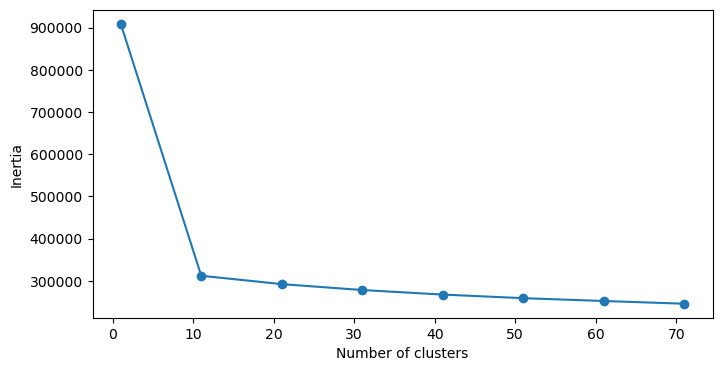

In [110]:
ncluster_search(1,72,10,base_v0_kmeans_0)

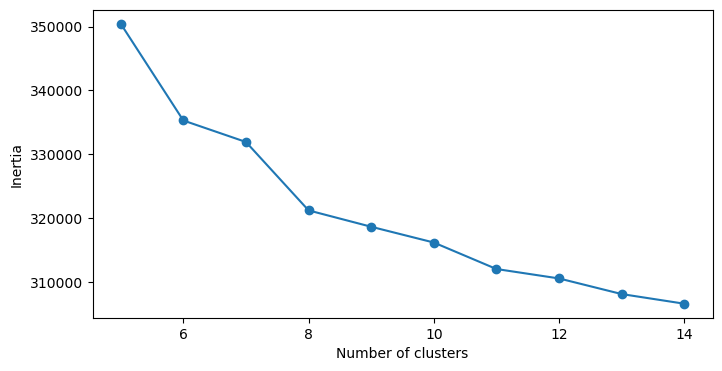

In [111]:
ncluster_search(5,15,1,base_v0_kmeans_0)

In [112]:
def importance_search(nclusters, data):
    
    data = data.drop('preds', axis=1)
    
    kmeans = KMeans(nclusters)
    kmeans.fit(data)
    predictions = kmeans.predict(data)
    
    features = data
    target = predictions
    
    model = RandomForestClassifier(random_state=SEED)
    model.fit(features, target)
    
    importances = pd.DataFrame({
    'feature': features.columns.astype('str'),
    'importance': model.feature_importances_})
    
    return importances


In [113]:
imp0 = importance_search(7, base_v0_kmeans_0)

In [114]:
imp0.sort_values(by='importance', ascending=False).head(20)

feature  importance
21      21    0.244442
63      63    0.023349
20      20    0.022062
11      11    0.021265
58      58    0.020986
33      33    0.020819
64      64    0.020327
46      46    0.020143
25      25    0.018541
35      35    0.017537
24      24    0.016911
42      42    0.016415
55      55    0.014816
8        8    0.014507
47      47    0.013268
71      71    0.013186
15      15    0.012953
30      30    0.012233
27      27    0.012109
38      38    0.011894

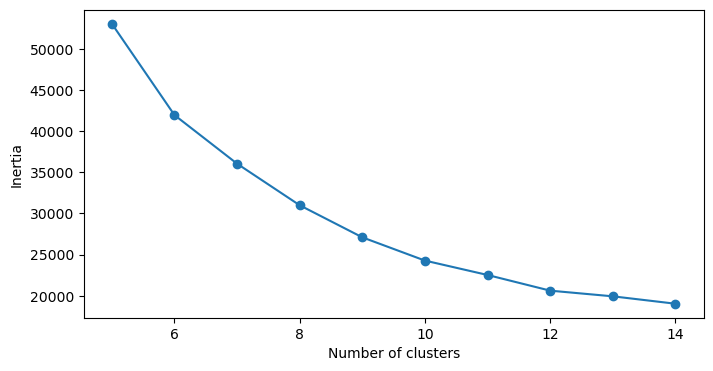

In [115]:
ncluster_search(5,15,1,base_v0_kmeans_1)

In [116]:
imp1 = importance_search(8, base_v0_kmeans_1)
imp1.sort_values(by='importance', ascending=False).head(20)

feature  importance
25      25    0.194785
44      44    0.033880
33      33    0.028963
42      42    0.018009
21      21    0.015868
22      22    0.014097
26      26    0.013662
59      59    0.013162
9        9    0.013054
57      57    0.012829
39      39    0.012707
55      55    0.012195
43      43    0.012137
3        3    0.011992
65      65    0.011978
27      27    0.011963
14      14    0.011958
4        4    0.011877
45      45    0.011779
71      71    0.011757

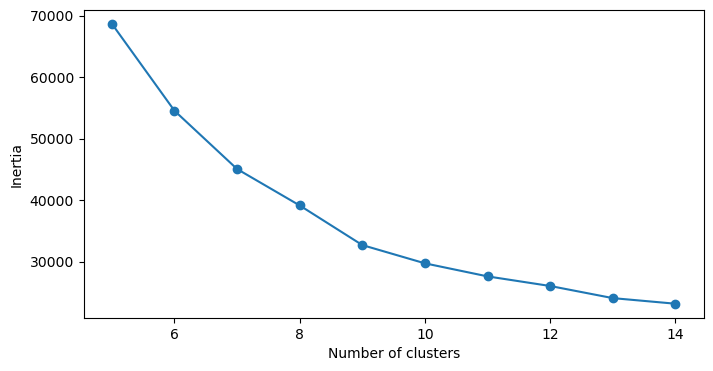

In [117]:
ncluster_search(5,15,1,base_v0_kmeans_2)

In [118]:
imp2 = importance_search(8, base_v0_kmeans_2)
imp2.sort_values(by='importance', ascending=False).head(20)

feature  importance
25      25    0.183404
22      22    0.027700
44      44    0.027321
33      33    0.021638
28      28    0.020740
49      49    0.016996
68      68    0.016798
70      70    0.014993
46      46    0.013354
48      48    0.013349
61      61    0.012918
10      10    0.012519
34      34    0.012295
62      62    0.012276
41      41    0.012169
40      40    0.012100
43      43    0.011923
35      35    0.011800
15      15    0.011732
9        9    0.011538

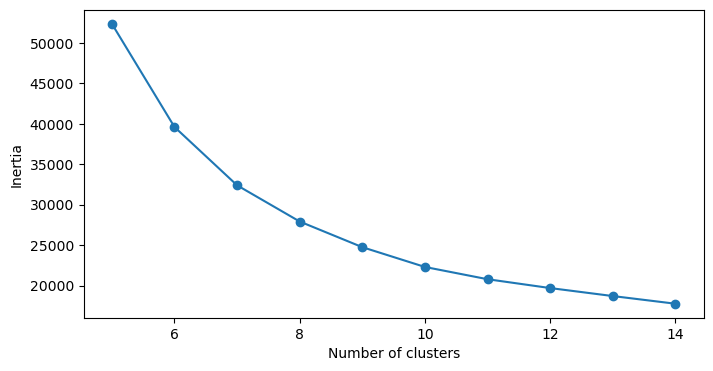

In [119]:
ncluster_search(5,15,1,base_v0_kmeans_3)

In [120]:
imp3 = importance_search(7, base_v0_kmeans_3)
imp3.sort_values(by='importance', ascending=False).head(20)

feature  importance
25      25    0.204806
6        6    0.015779
35      35    0.015327
48      48    0.015190
37      37    0.014998
49      49    0.014935
51      51    0.014607
44      44    0.013825
57      57    0.013721
26      26    0.013315
65      65    0.013300
14      14    0.012853
24      24    0.012802
66      66    0.012749
20      20    0.012519
27      27    0.012481
41      41    0.012470
56      56    0.012429
71      71    0.012296
50      50    0.012265

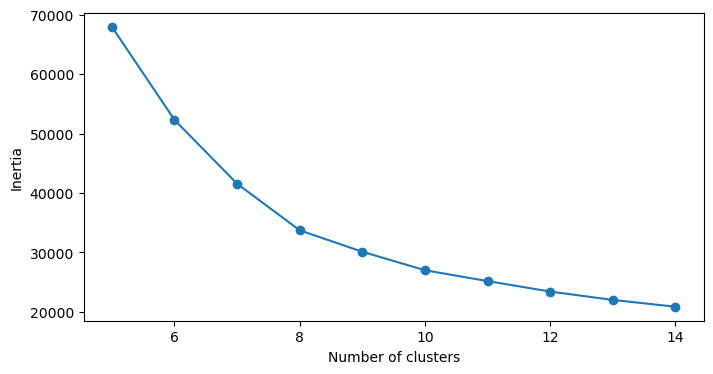

In [121]:
ncluster_search(5,15,1,base_v0_kmeans_4)

In [122]:
imp4 = importance_search(7, base_v0_kmeans_4)
imp4.sort_values(by='importance', ascending=False).head(20)

feature  importance
25      25    0.212682
22      22    0.016069
32      32    0.015349
2        2    0.013674
27      27    0.013624
63      63    0.013509
38      38    0.013468
64      64    0.013413
24      24    0.013302
30      30    0.013150
42      42    0.013124
35      35    0.013092
55      55    0.012969
62      62    0.012874
60      60    0.012582
40      40    0.012561
11      11    0.012381
43      43    0.011913
41      41    0.011847
46      46    0.011826

In [123]:
def find_best(data):
    data = data.sort_values(by='importance', ascending=False).head(5)
    return data

In [124]:
imp0 = find_best(imp0)
imp1 = find_best(imp1)
imp2 = find_best(imp2)
imp3 = find_best(imp3)
imp4 = find_best(imp4)

Соберем общий список из наиболее значимых признаков:

In [125]:
total_imp = pd.concat([imp0, imp1, imp2, imp3, imp4])
total_imp = total_imp['feature'].drop_duplicates()
total_imp

21    21
63    63
20    20
11    11
58    58
25    25
44    44
33    33
42    42
22    22
28    28
6      6
35    35
48    48
37    37
32    32
2      2
27    27
Name: feature, dtype: object

Т.к. лучшее значение метрики было получено на нормированных данных после удаления признаков, не распределенных нормально, будем использовать эти данные для дальнейшей работы. Оставим в списке только те признаки, которые не были удалены:

In [126]:
columns_to_keep = []
for i in total_imp.unique():
    if i in df_base_norm_rs.columns:
        columns_to_keep.append(i)

columns_to_keep

['63',
 '20',
 '11',
 '58',
 '33',
 '42',
 '22',
 '28',
 '35',
 '48',
 '37',
 '32',
 '2',
 '27']

In [127]:
df_base_norm_rs_k2 = pd.DataFrame()
df_train_norm_rs_k2 = pd.DataFrame()

for i in columns_to_keep:
    df_base_norm_rs_k2[str(i)] = df_base_norm_rs[[str(i)]] 

for i in columns_to_keep:
    df_train_norm_rs_k2[str(i)] = df_train_norm_rs[[str(i)]] 

In [128]:
df_base_norm_rs_k2 = df_base_norm_rs_k2.to_numpy()
df_train_norm_rs_k2 = df_train_norm_rs_k2.to_numpy()

In [129]:
dims = pd.DataFrame(df_base_norm_rs_k2).shape[1]
n_cells = 10
quantizer2 = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer2, dims, n_cells)

In [130]:
idx_l2.train(np.ascontiguousarray(df_base_norm_rs_k2[:10000, :]))
idx_l2.add(np.ascontiguousarray(df_base_norm_rs_k2))

In [132]:
vecs, idx = idx_l2.search(np.ascontiguousarray(df_train_norm_rs_k2).astype('float32'), k)

acc = 0
for target, el in zip(targets.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])

print(100 * acc / len(idx))

51.728


Таким образом, добавление 2 уровня кластеризации и сокращение признаков на его основе также ухудшает качество модели.

## Иерархическая кластеризация

In [133]:
df_base_norm_rs.dtypes

0     float32
1     float32
2     float32
3     float32
4     float32
       ...   
66    float32
67    float32
68    float32
69    float32
71    float32
Length: 66, dtype: object

Рассчитаем матрицу расстояний и сформируем кластеры:

In [134]:
dist_matrix = distance_matrix(df_base_norm_rs[:10000],df_base_norm_rs[:10000]) 

In [135]:
Z = linkage(dist_matrix, 'complete')

C:\Users\Танька\AppData\Local\Temp\ipykernel_12236\3829826551.py:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(dist_matrix, 'complete')


Отобразим получившиеся кластеры:

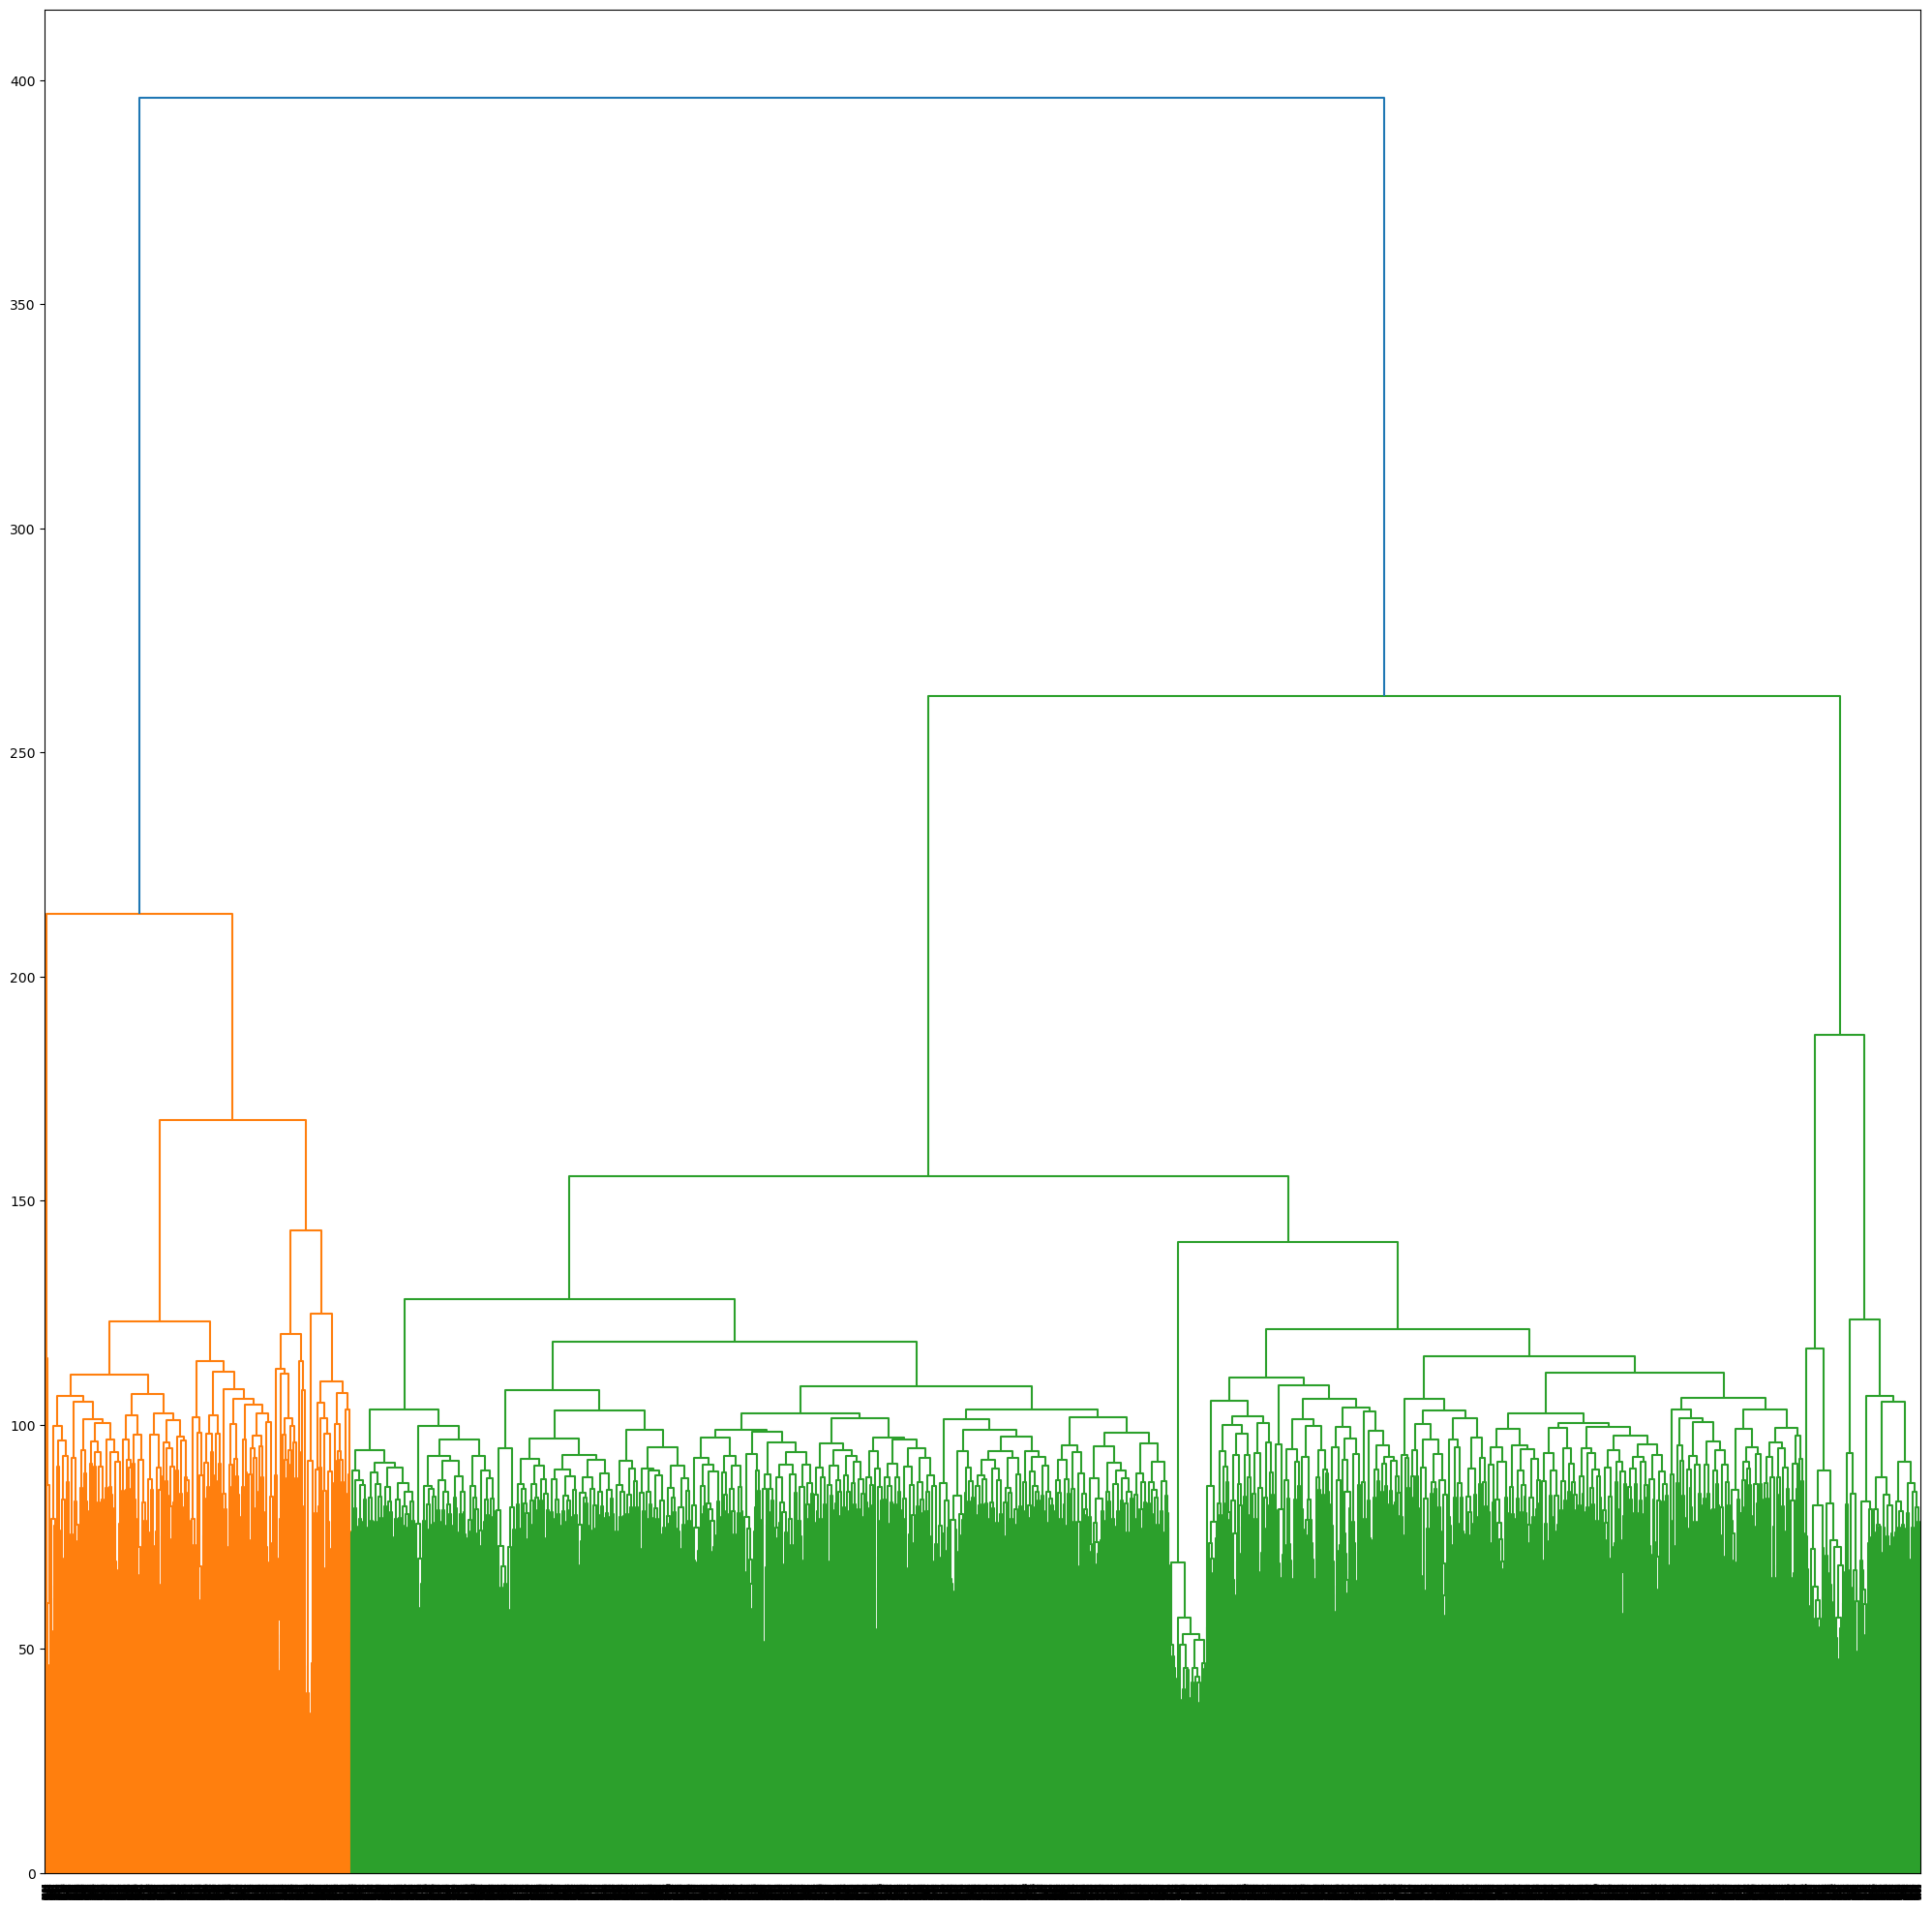

In [136]:
fig = plt.figure(figsize=(25,25))
dend = dendrogram(Z)
plt.show()

Рассмотрим подробнее последние 60 слияний:

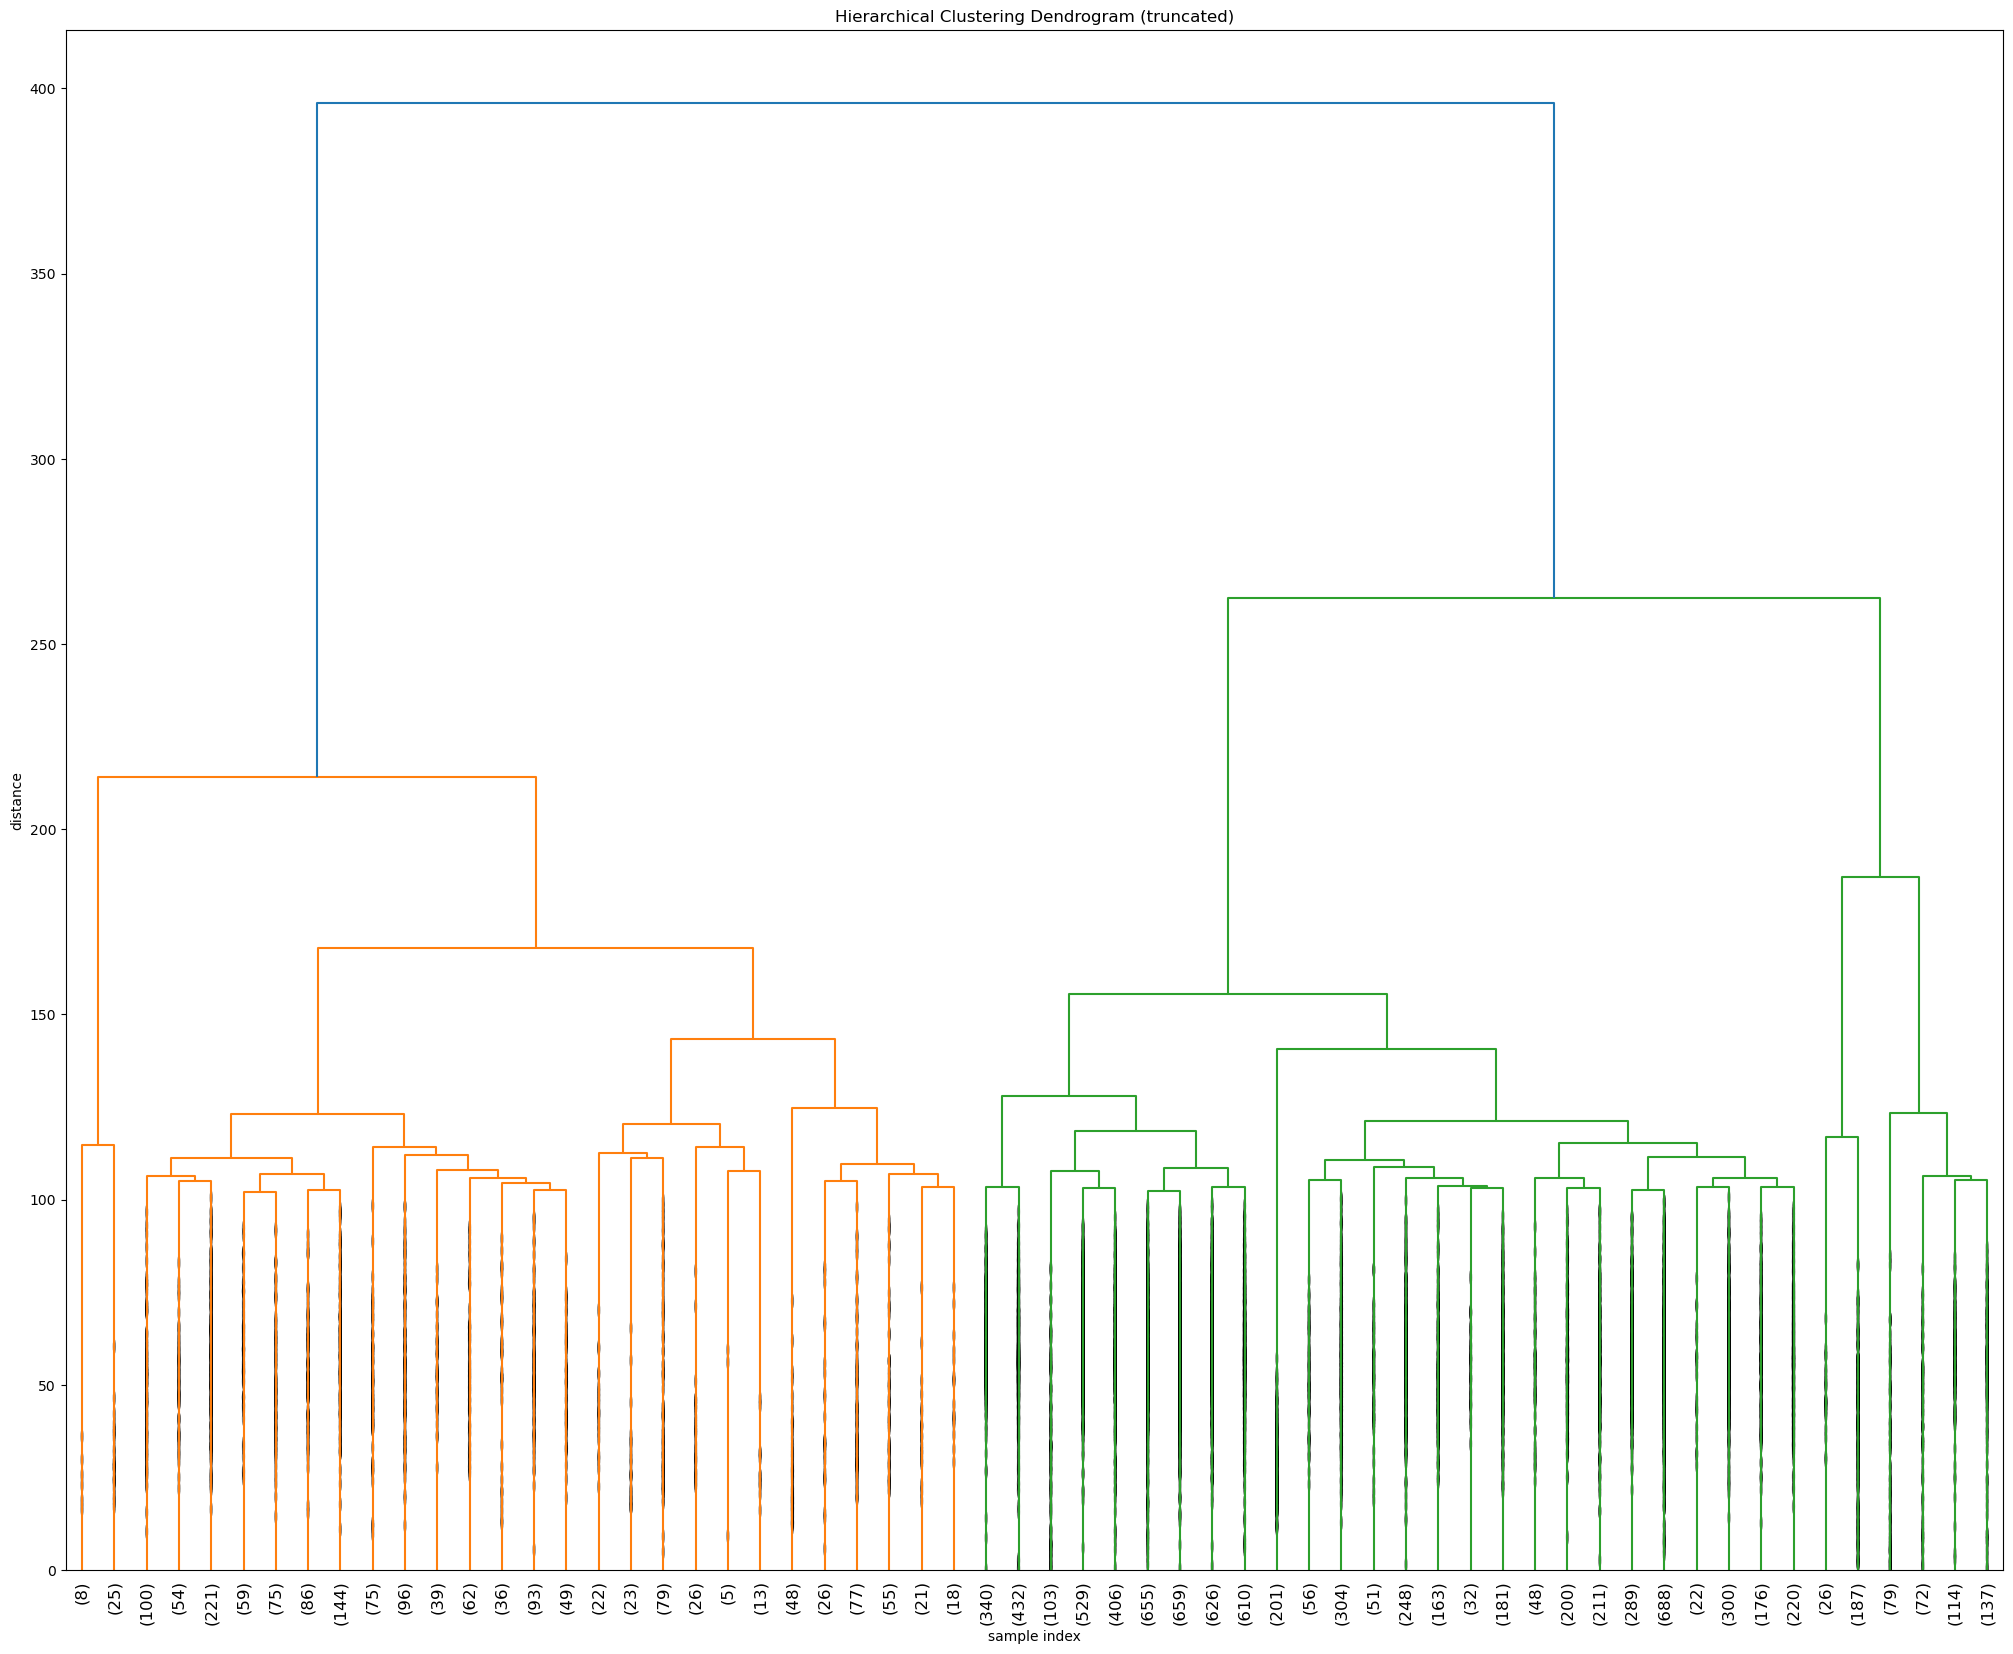

In [137]:
fig = plt.figure(figsize=(25,20))
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    truncate_mode='lastp',  
    p=60,  
    show_leaf_counts=True, 
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  
)
plt.show()

Оценим качество получающейся кластеризации при использовании разных метрик:

In [139]:
metrics = ['euclidean', 'cityblock', 'chebyshev', 'cosine']

for metr in metrics:
    #linkage_matrix = linkage(df_base_norm_rs[:10000], metric=metr)
    Z = linkage(dist_matrix, method='complete', metric=metr)
    coef, coph_dist = cophenet(Z, distance.pdist(df_base_norm_rs[:10000]))
    print(f'{metr}: {coef}')

C:\Users\Танька\AppData\Local\Temp\ipykernel_12236\938008902.py:5: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(dist_matrix, method='complete', metric=metr)


euclidean: 0.24560372233193029
cityblock: -0.1562071498432814
chebyshev: 0.17479660426162788
cosine: 0.005571873593556959


Кластеризация требует дополнительной проработки. Тем не менее, лучшие значения получаются при использовании евклидова расстояния. Дальше протестируем работу модели на основе такой кластеризации:

In [140]:
 Z = linkage(dist_matrix, method='complete', metric='euclidean')

C:\Users\Танька\AppData\Local\Temp\ipykernel_12236\1384834937.py:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(dist_matrix, method='complete', metric='euclidean')


На основе дендограммы выше примем пороговое значения расстояния для образования нового кластера в 120. Найдем получающееся количество кластеров:

In [141]:
max_d = 120
clusters = fcluster(Z, max_d, criterion='distance')
sorted(pd.Series(clusters).unique())

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

In [142]:
df_base_norm_rs10 = df_base_norm_rs[:10000]
df_train_norm_rs10 = df_train_norm_rs[:10000]

In [143]:
df_base_norm_rs10['cluster'] = clusters
df_base_norm_rs10.head()

C:\Users\Танька\AppData\Local\Temp\ipykernel_12236\36318647.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_base_norm_rs10['cluster'] = clusters


0         1         2         3         4         5         7  \
Id                                                                             
0-base -0.853397  0.460538 -0.412746  1.049610  1.690894 -0.841724  0.273315   
1-base  1.528277  0.782926 -0.520104 -0.743363 -0.875959 -0.364060 -0.655240   
2-base  0.946431 -0.245443  0.292514  0.502795  0.630760 -0.706570  0.482669   
3-base -0.038115 -0.591736 -0.880887 -1.440728 -0.573874  0.332243 -0.631718   
4-base  0.398938 -0.224341  1.752062  0.232106 -1.714228 -1.031150  0.283002   

               8         9        10        11        12        13        14  \
Id                                                                             
0-base -0.350781  0.678173  0.319060  0.552683 -0.328693  0.565938  0.723050   
1-base -0.491795  0.839484  0.007432 -0.827379 -0.549448  0.003754 -0.134922   
2-base  0.596146  0.478435  0.016141  0.698598 -0.217600 -0.113005 -0.188959   
3-base -0.219211  0.149039  0.600837 -0.502068 -0.810788 -1.775983 -0.773189   
4-base -0.203272 -0.133156  0.567004  0.457219 -0.189832 -0.701793 -0.303959   

              15        16        17        18        19        20        22  \
Id                                                                             
0-base -0.296207 -0.146400  0.250819  0.761268 -0.289055 -0.170499 -0.371385   
1-base  1.818578  0.567501  0.944443 -1.801075 -1.102990  0.418638  0.006817   
2-base  0.049990 -0.213675  0.202902  0.417870  0.148982  0.400964  0.085095   
3-base -0.923137 -0.131607  0.390436  0.198984  0.069116 -0.276995 -1.686450   
4-base  0.883804  0.349019  1.823374  0.099439 -0.138018  1.055462  0.363871   

              23        24        26        27        28        29        30  \
Id                                                                             
0-base -0.120435 -1.504513  0.299484 -1.291385 -0.686013 -0.215061  0.028645   
1-base  0.283470  0.750867  0.843638  0.124570  0.711877 -0.260557  0.092403   
2-base  0.584656  0.689338 -0.474187  0.396669 -0.142851 -0.019179 -0.263668   
3-base -0.697512 -0.838566 -1.415763 -0.271920  0.348902 -0.033051  0.558319   
4-base  0.060669  0.933282 -0.127985  0.794232  0.948814  1.175662 -0.841830   

              31        32        33        34        35        36        37  \
Id                                                                             
0-base  0.024487 -0.186111 -0.018366 -0.608206  1.320213  0.581792 -0.497595   
1-base -0.663755  0.380699  0.524675 -0.343963 -0.758643  1.407335 -0.137999   
2-base -0.015895 -1.017283 -0.584739  0.550198  0.185107  0.082753 -0.251334   
3-base  0.201583 -0.744834  0.000000  0.155904  0.650948 -0.639643  0.125416   
4-base -0.088011  0.296324 -0.298545  1.140588 -0.126773 -0.572538  0.851891   

              38        39        40        41        42        43        45  \
Id                                                                             
0-base -0.282972  0.089570 -0.300862 -1.022947 -0.513114 -0.687012 -0.928814   
1-base  0.464452  0.338119  0.071072  1.194666  0.280604 -1.272124  0.078409   
2-base -0.009140  0.043627 -0.524561 -0.735514  0.247282 -0.330359  0.155093   
3-base -0.320646  0.198991 -0.754308  0.807145 -0.148218  0.031409  1.030259   
4-base -0.287635 -0.104917 -0.126428  0.535681 -0.710607  1.499619  0.175973   

              46        47        48        49        50        51        52  \
Id                                                                             
0-base -0.161477 -0.008977  0.726296 -1.823928 -0.989698  1.186831  0.624175   
1-base -0.955020 -0.674943 -1.710352 -0.010994  0.404228 -0.499233 -0.211180   
2-base  0.878370  0.157651 -0.427468  0.084238  0.528631 -0.473049 -0.050986   
3-base -0.108753  0.962310 -0.292733  0.035444 -0.276209  1.248586 -0.212863   
4-base  1.361113 -0.969472  0.176973 -0.498078 -0.726321 -0.172344 -0.717774   

              53        54        55        56        57        58        59  \
Id      

In [144]:
rf2_features = df_base_norm_rs10.drop('cluster', axis=1)
rf2_target = df_base_norm_rs10['cluster']

In [145]:
model = RandomForestClassifier(random_state=SEED)
model.fit(rf2_features, rf2_target)

RandomForestClassifier(random_state=123)

In [146]:
importances3_df = pd.DataFrame({
    'feature': rf2_features.columns.astype('str'),
    'importance': model.feature_importances_
}).sort_values(by='importance', ascending=False)

importances3_df.head(20)

feature  importance
59      63    0.026043
41      45    0.019013
20      22    0.018424
32      35    0.018313
29      32    0.017416
45      49    0.017267
39      42    0.016922
65      71    0.016917
48      52    0.016546
5        5    0.016479
53      57    0.016448
17      18    0.016362
36      39    0.016203
44      48    0.016140
14      15    0.016078
58      62    0.015957
61      66    0.015861
15      16    0.015792
0        0    0.015640
7        8    0.015589

Подберем такое количество признаков, при котором метрика максимальна:

In [147]:
n_best = 0
acc_best = 0
df_base_cluster_imp_fin = pd.DataFrame()
df_train_cluster_imp_fin = pd.DataFrame()


for i in range(25,55,5):
    df_base_cluster_imp = df_base[importances3_df.sort_values(by='importance', 
                                                              ascending=False).head(i)['feature'].unique()]
    df_train_cluster_imp = df_train[importances3_df.sort_values(by='importance', 
                                                                ascending=False).head(i)['feature'].unique()]
    
    df_base_cluster_imp_rs = scaler.fit_transform(df_base_cluster_imp)
    df_train_cluster_imp_rs = scaler.transform(df_train_cluster_imp)
    
    dims = pd.DataFrame(df_base_cluster_imp_rs).shape[1]
    n_cells = 10

    quantizer2 = faiss.IndexFlatL2(dims)
    idx_l2 = faiss.IndexIVFFlat(quantizer2, dims, n_cells)

    idx_l2.train(np.ascontiguousarray(df_base_cluster_imp_rs[:10000, :]).astype('float32'))
    idx_l2.add(np.ascontiguousarray(df_base_cluster_imp_rs).astype('float32'))
    
    vecs, idx = idx_l2.search(np.ascontiguousarray(df_train_cluster_imp_rs).astype('float32'), k)

    acc = 0
    for target, el in zip(targets.values.tolist(), idx.tolist()):
        acc += int(target in [base_index[r] for r in el])
   
    if acc > acc_best:
        acc_best = (100 * acc/ len(idx))
        n_best = i
        
        df_base_cluster_imp_fin = df_base[importances3_df.sort_values(by='importance', 
                                                              ascending=False).head(i)['feature'].unique()]
        df_train_cluster_imp_fin = df_train[importances3_df.sort_values(by='importance', 
                                                                ascending=False).head(i)['feature'].unique()]
        
print(n_best)
print(acc_best)

50
68.396


Таким образом, при использовании 50 признаков, выделенных путем иерархической классификации, качество модели на 10000 строках незначительно увеличилось. 

In [148]:
df_base_cluster_imp_rs = scaler.fit_transform(df_base_cluster_imp_fin)
df_train_cluster_imp_rs = scaler.transform(df_train_cluster_imp_fin)

Подберем количество кластеров:

In [149]:
n_fin = 0
acc_fin = 0

for n in range(10,50,5):
        
    dims = pd.DataFrame(df_base_cluster_imp_rs).shape[1]
    quantizer2 = faiss.IndexFlatL2(dims)
    idx_l2 = faiss.IndexIVFFlat(quantizer2, dims, n)

    idx_l2.train(np.ascontiguousarray(df_base_cluster_imp_rs[:10000, :]).astype('float32'))
    idx_l2.add(np.ascontiguousarray(df_base_cluster_imp_rs).astype('float32'))
    
    vecs, idx = idx_l2.search(np.ascontiguousarray(df_train_cluster_imp_rs).astype('float32'), k)

    for target, el in zip(targets.values.tolist(), idx.tolist()):
        acc += int(target in [base_index[r] for r in el])

    print(100 * acc / len(idx))
    
    if acc > acc_fin:
        acc_best = acc
        n_fin = n
        
print(n_fin)
print(100 *acc_best/ len(idx))

136.792
204.966
272.968
340.893
408.556
475.98
543.493
610.871
45
610.871


## Проверка метрики на полном объеме данных

Проверим качество модели с использованием полной выборки на ограниченном количестве признаков и с подобранным количеством кластеров:

In [150]:
dims = pd.DataFrame(df_base_cluster_imp_rs).shape[1]
n_cells = n_fin
quantizer2 = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer2, dims, n_cells)

In [151]:
idx_l2.train(np.ascontiguousarray(df_base_cluster_imp_rs).astype('float32'))
idx_l2.add(np.ascontiguousarray(df_base_cluster_imp_rs).astype('float32'))

In [152]:
vecs, idx = idx_l2.search(np.ascontiguousarray(df_train_cluster_imp_rs).astype('float32'), k)

acc = 0
for target, el in zip(targets.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])

print(100 * acc / len(idx))

67.466


Использование признаков, полученных с пом. иерархической кластеризации, а также оптимизация количества кластеров, позволила повысить метрику с 66.848 до 67,466. 

## Проверка метрики без удаления признаков на основе иерархической кластеризации

Проверим, получится ли добиться более высоких результатов метрики без удаления доп. признаков, а оставив только оптимальное число кластеров:

In [155]:
dims = pd.DataFrame(df_base_norm_rs_np).shape[1]
n_cells = n_fin
quantizer2 = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer2, dims, n_cells)

In [156]:
idx_l2.train(np.ascontiguousarray(df_base_norm_rs_np[:10000, :]).astype('float32'))
idx_l2.add(np.ascontiguousarray(df_base_norm_rs_np).astype('float32'))

In [157]:
vecs, idx = idx_l2.search(np.ascontiguousarray(df_train_norm_rs_np).astype('float32'), k)

In [158]:
acc = 0
for target, el in zip(targets.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])

In [159]:
print(100 * acc / len(idx))

67.358


При использовании только заданного числа кластеров метрика ухудшается на 1%.

## Получение предсказаний

Найдем наиболее похожие товары для списка из валидационной выборки:

In [164]:
def find_products(data):
    data = data.drop(columns=columns_to_del)
    
    data_cluster_imp = data[importances3_df.sort_values(by='importance', 
                                                        ascending=False).head(n_best)['feature'].unique()]
    data = scaler.transform(data_cluster_imp)
    
    dims = pd.DataFrame(df_base_cluster_imp_rs).shape[1]
    n_cells = n_fin
    
    quantizer2 = faiss.IndexFlatL2(dims)
    idx_l2 = faiss.IndexIVFFlat(quantizer2, dims, n_cells)
    
    idx_l2.train(np.ascontiguousarray(df_base_cluster_imp_rs).astype('float32'))
    idx_l2.add(np.ascontiguousarray(df_base_cluster_imp_rs).astype('float32'))

    vecs, idx = idx_l2.search(np.ascontiguousarray(data).astype('float32'), k)
       
    return idx

In [165]:
find_products(df_valid)

array([[2192372, 2504096, 1225777, ...,  236355, 2366011,  331374],
       [2528494, 1584915,  135315, ...,  377163,  435080,  536195],
       [ 431806,  628853,   19678, ...,  918434,  344807, 1668082],
       ...,
       [1392746,  482200, 1292637, ..., 2703390,  452732,  267390],
       [ 319526,   77792, 2637837, ...,  189036, 2906948, 1283729],
       [2888788, 1811737, 2900327, ..., 2631993, 1299112, 1654404]],
      dtype=int64)

## Выводы

Таким образом, наилучшие показатели качества поиска похожих товаров удалось достичь с помощью:
 - библиотки FAISS,
 - масштабирования признаков с помощью RobustScaler,
 - удаления признаков, распределение которых отклонялось от нормального,
 - выделения наиболее значимых признаков с помощью иерархической кластеризации.
 
 Accuracy@5 составила 67.466.